In [1]:
####################################################################
## Code to run multi-set CCA on various mouse tumors (scRNA-seq)
## This codes uses Seurat version 2.3.4
## Author: Chaitanya Acharya
## Updated: July 7, 2019
####################################################################
## Set your working directory
setwd("~/Research/Josh") ## setwd("your directory")

## Load the required R libraries
## If the libraries are not installed, use BiocManager
lib.list=c("Seurat","plyr","ggpubr","dplyr","ggthemes","data.table","GSVA","biomaRt")

for(i in 1:length(lib.list)){
	if(any(installed.packages()[,1]==lib.list[i])){
		library(lib.list[i],character.only=T)}else{
			BiocManager::install(lib.list[i])
			library(lib.list[i],character.only=T)
    };
}

## R scripts with utility functions
source("~/Research/scripts/r_scripts/useful_functions.R")
source("~/Research/scripts/r_scripts/plotfns.R")

Loading required package: ggplot2
Loading required package: cowplot

Attaching package: ‘cowplot’

The following object is masked from ‘package:ggplot2’:

    ggsave

Loading required package: Matrix
Registered S3 method overwritten by 'R.oo':
  method        from       
  throw.default R.methodsS3
Loading required package: magrittr

Attaching package: ‘ggpubr’

The following object is masked from ‘package:plyr’:

    mutate

The following object is masked from ‘package:cowplot’:

    get_legend


Attaching package: ‘dplyr’

The following objects are masked from ‘package:plyr’:

    arrange, count, desc, failwith, id, mutate, rename, summarise,
    summarize

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Attaching package: ‘ggthemes’

The following object is masked from ‘package:cowplot’:

    theme_map


Attaching package: ‘data.table’

The following objects are 

All the required packages and R functions are loaded. Our next step includes reading all the individual tumor datasets using "Seurat" R package (version 2.3.4) and follow their primary analysis workflow, which includes filtering, normalization, scaling (while regressing out any known technical variables) and identifying variable genes.

But first, we read in mouse gene-sets, human PAM50 genes and identified homologous mouse genes, cell-cycle genes (separeately for S and G2M phases).

In [3]:
### Read the gene-set file
ach = read.gmt.file("~/Research/pathways/mouse_pathways/acharya_genesets_mouse.gmt")
pam50_mm = scan("~/Research/pathways/pam50_mm_genes.txt",what="")
ach$geneset.descriptions[51]="PAM50_mouse_homologs"
ach$geneset.names[51]="PAM50"
ach$genesets[[51]]=pam50_mm
names(ach$genesets)[51]="PAM50"

## Cell cycle genes
cc_genes = scan("~/Research/Josh/cell_cycle_vignette_files/regev_lab_cell_cycle_genes.txt",what="")
head(cc_genes)
# We can segregate this list into markers of G2/M phase and markers of S phase and convert them from human to mouse markers
s_genes = convertHumanGeneList(cc_genes[1:43])
s_genes
g2m_genes = convertHumanGeneList(cc_genes[44:97])
g2m_genes

Number of genesets read:  50 


[1] "Ubr7"     "Mcm4"     "Fen1"     "Cdc45"    "Slbp"     "Dscc1"   
 [7] "Ccne2"    "Ung"      "Hells"    "Nasp"     "Prim1"    "Usp1"    
[13] "Clspn"    "Casp8ap2" "Wdr76"    "Gins2"    "Tipin"    "Msh2"    
[19] "Pcna"     "Mcm6"     "Tyms"     "Rad51"    "Blm"      "Brip1"   
[25] "Rrm2"     "Dtl"      "Rfc2"     "Mcm5"     "Gmnn"     "Uhrf1"   
[31] "Rpa2"     "Pola1"    "Cdca7"    "Exo1"     "E2f8"     "Mcm2"    
[37] "Rad51ap1" "Chaf1b"   "Rrm1"     "Cdc6"

[1] "Dlgap5"  "Gas2l3"  "Psrc1"   "Cks2"    "Hmmr"    "Tacc3"   "Cdca8"  
 [8] "Cdc20"   "Smc4"    "Tubb4b"  "Kif2c"   "Cdca2"   "Anp32e"  "Cenpa"  
[15] "Ect2"    "Ttk"     "Cdk1"    "Rangap1" "Kif11"   "Ndc80"   "Ckap2l" 
[22] "Gtse1"   "Nuf2"    "Birc5"   "Nusap1"  "Cks1b"   "Cks1brt" "Anln"   
[29] "G2e3"    "Ube2c"   "Nek2"    "Ckap5"   "Cdca3"   "Cdc25c"  "Ccnb2"  
[36] "Ckap2"   "Hmgb2"   "Mki67"   "Lbr"     "Ncapd2"  "Ctcf"    "Cenpe"  
[43] "Cenpf"   "Aurkb"   "Tpx2"    "Hjurp"   "Kif20b"  "Tmpo"    "Aurka"  
[50] "Cbx5"    "Bub1"    "Top2a"

Read all the .tsv files and load them as "Seurat" objects. Each .tsv file represents a tumor sample.

In [4]:
### Read all the possible .tsv files and identity select files
### Create a list object containing gene expression matrices of the select files
files = list.files(pattern=".tsv")
files = files[files %in% c("MT1.tsv","TU1.tsv","TU2.tsv","TU3.tsv","TU4.tsv")]
data_list = llply(1:length(files),.progress="time",function(i) read.delim(files[i],header=T,row.names=1))

### Create a SEURAT object from each gene expression matrix within the list
### Each SEURAT object is preprocessed separately and highly variable genes are computed
seu_list = gene_list = vector(mode="list",length=length(data_list))
for(i in 1:length(seu_list)){
  print(i)
  seu = CreateSeuratObject(raw.data=data_list[[i]],min.cells=5)
  seu@meta.data$group = gsub(".tsv","",files[i])
  seu = FilterCells(seu, subset.names = "nGene", low.thresholds = round(quantile(seu@meta.data$nGene,0.1)), high.thresholds = Inf)
  seu = NormalizeData(seu,display.progress = F)
  seu = CellCycleScoring(seu, s.genes = s_genes, g2m.genes = g2m_genes, set.ident = F)
  seu@meta.data$CC.Difference = seu@meta.data$S.Score - seu@meta.data$G2M.Score
  seu = ScaleData(seu, display.progress = F,vars.to.regress = c("nUMI"))
  seu = FindVariableGenes(seu,display.progress = F, do.plot = F, mean.function = ExpMean, dispersion.function = LogVMR)
  genes_use = head(rownames(seu@hvg.info), 2000)
  seu_list[[i]] = seu
  gene_list[[i]] = genes_use
}  

|====================================================|100%                      Completed after 30 s 
[1] 1
[1] 2
[1] 3
[1] 4
[1] 5


Run the multi-CCA pipeline that "Seurat" recently published. 
1) Identify common genes first, 2) RunMultiCCA()

In [6]:
#######################################################################################
## Gene selection for CCA
## We find genes that are highly variable in at least two datasets
#######################################################################################

genes_use <- names(which(table(unlist(gene_list)) > 1))
for (i in 1:length(seu_list)) {
    print(i)
  genes_use <- genes_use[genes_use %in% rownames(seu_list[[i]]@scale.data)]
}

[1] 1
[1] 2
[1] 3
[1] 4
[1] 5


[1] "Computing CC 1"
[1] "Computing CC 2"
[1] "Computing CC 3"
[1] "Computing CC 4"
[1] "Computing CC 5"
[1] "Computing CC 6"
[1] "Computing CC 7"
[1] "Computing CC 8"
[1] "Computing CC 9"
[1] "Computing CC 10"
[1] "Computing CC 11"
[1] "Computing CC 12"
[1] "Computing CC 13"
[1] "Computing CC 14"
[1] "Computing CC 15"
[1] "Computing CC 16"
[1] "Computing CC 17"
[1] "Computing CC 18"
[1] "Computing CC 19"
[1] "Computing CC 20"


Scaling data matrix


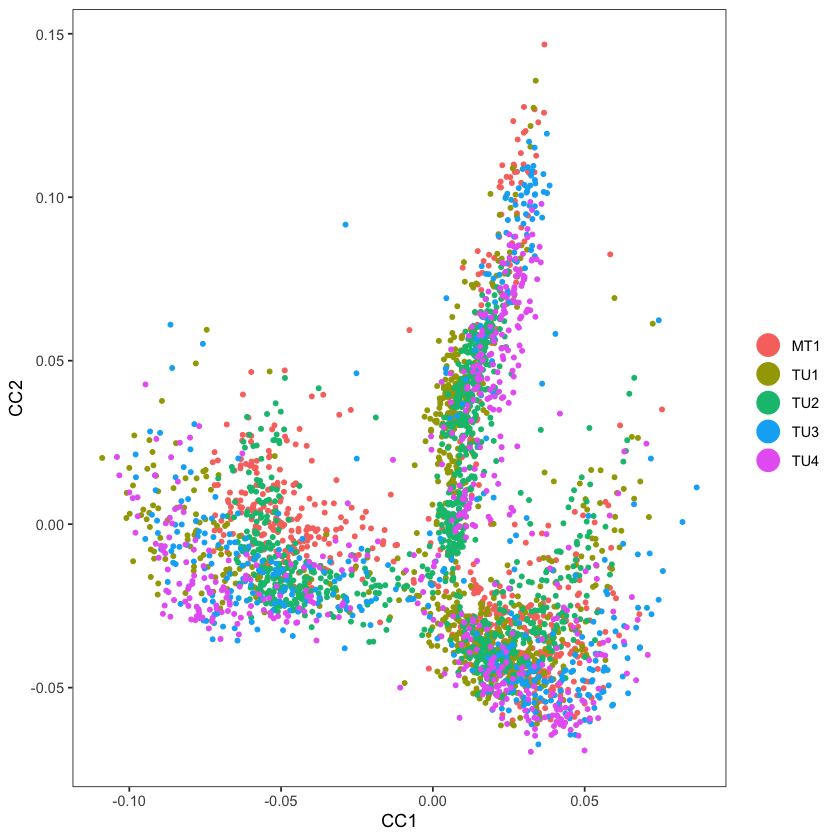

`geom_smooth()` using method = 'loess' and formula 'y ~ x'


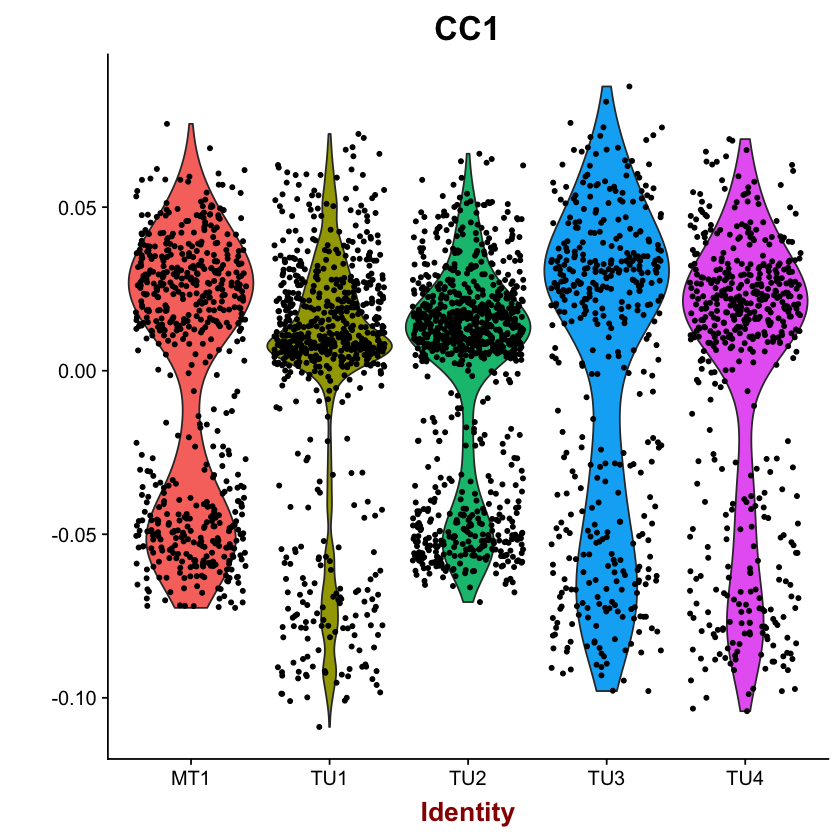

`geom_smooth()` using method = 'loess' and formula 'y ~ x'


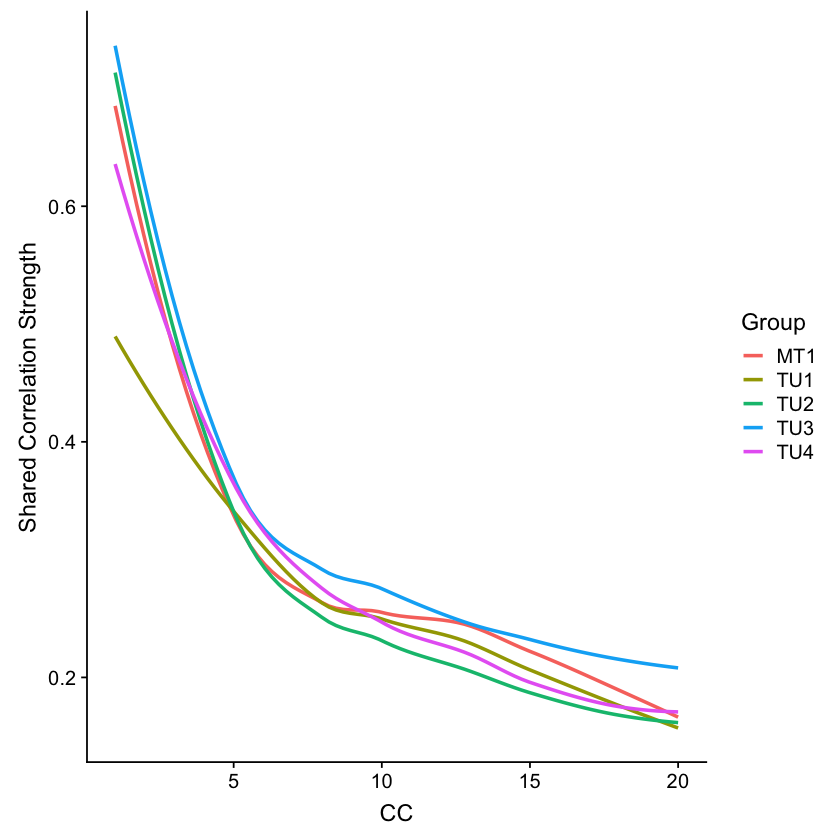

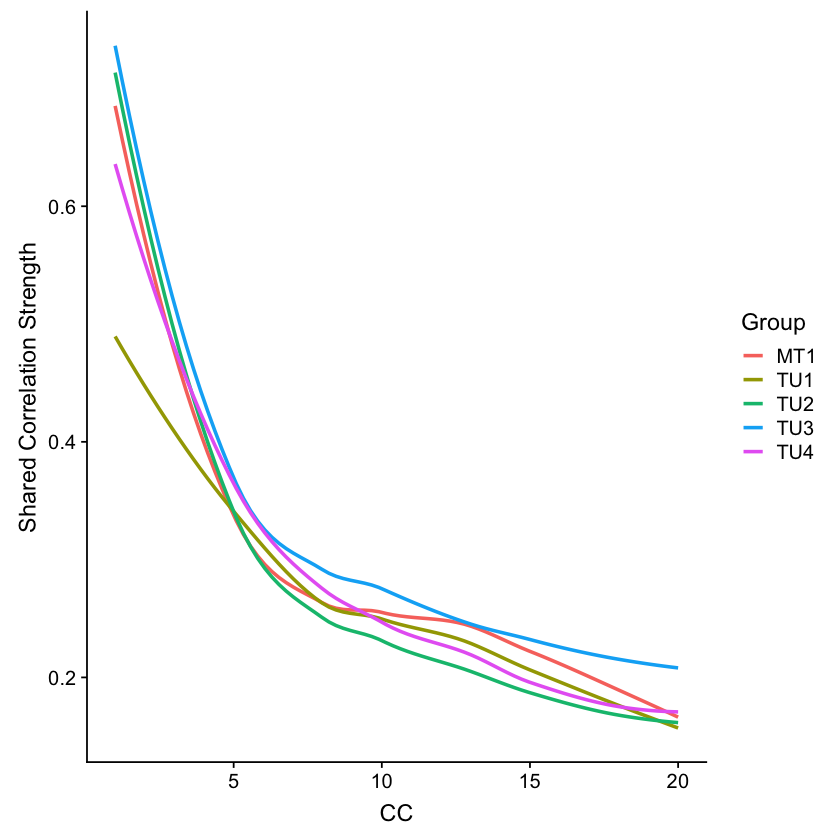

Scaling data matrix
Scaling data matrix
Scaling data matrix
Scaling data matrix
Scaling data matrix


Number of PCs:  1  Alignment metric:  0.8598901 
Number of PCs:  2  Alignment metric:  0.8102392 
Number of PCs:  3  Alignment metric:  0.7999657 
Number of PCs:  4  Alignment metric:  0.750973 
Number of PCs:  5  Alignment metric:  0.6833791 
Number of PCs:  6  Alignment metric:  0.6763107 
Number of PCs:  7  Alignment metric:  0.6944254 
Number of PCs:  8  Alignment metric:  0.6969151 
Number of PCs:  9  Alignment metric:  0.6925652 
Number of PCs:  10  Alignment metric:  0.684209 


[1] 0.7999657

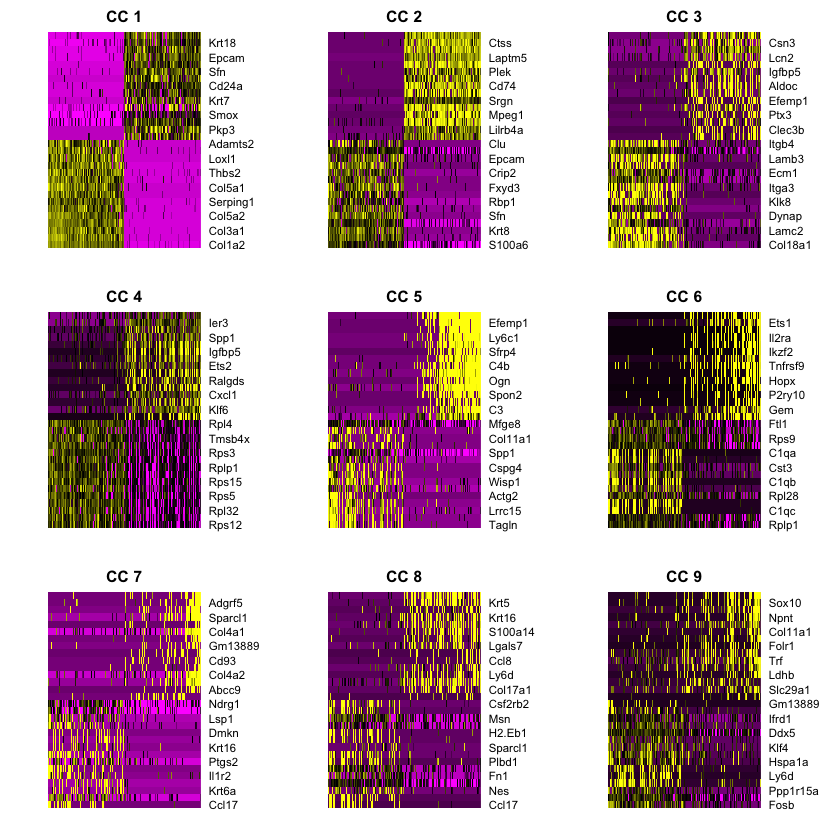

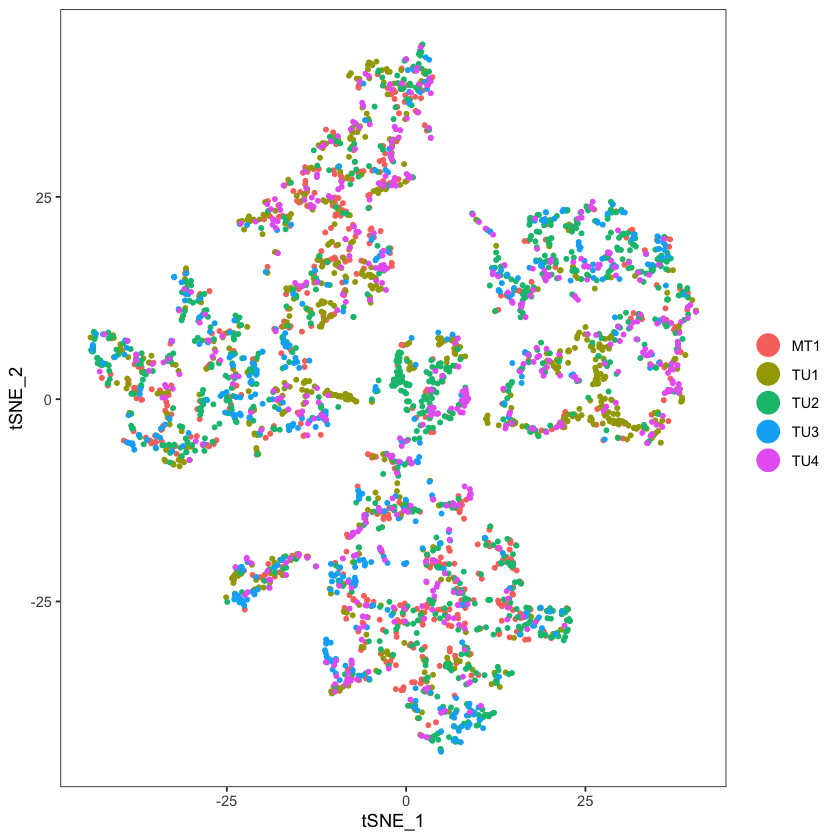

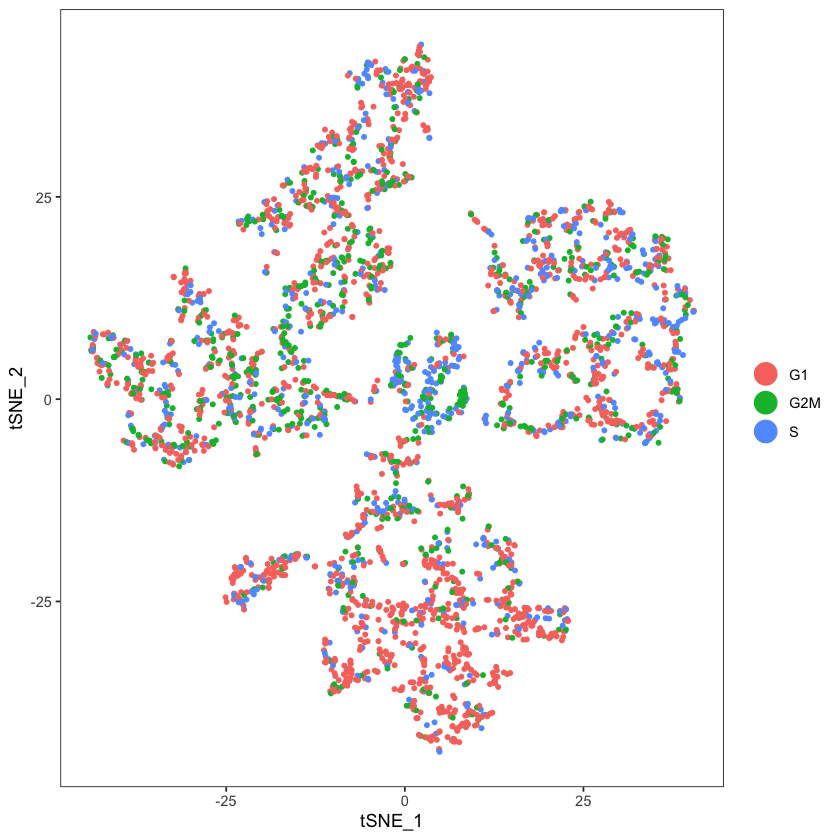

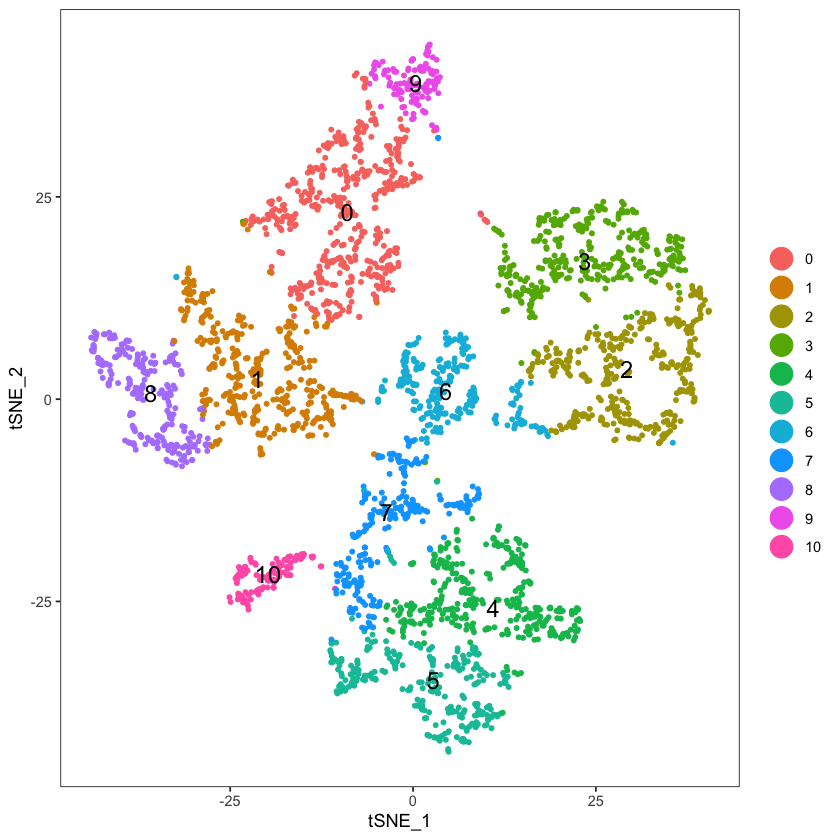

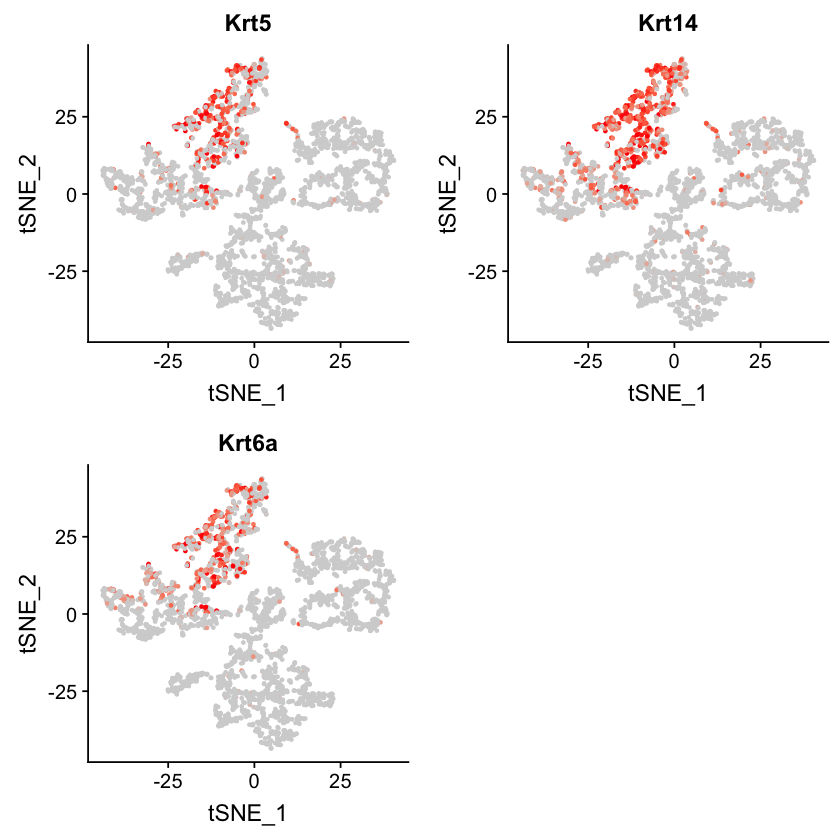

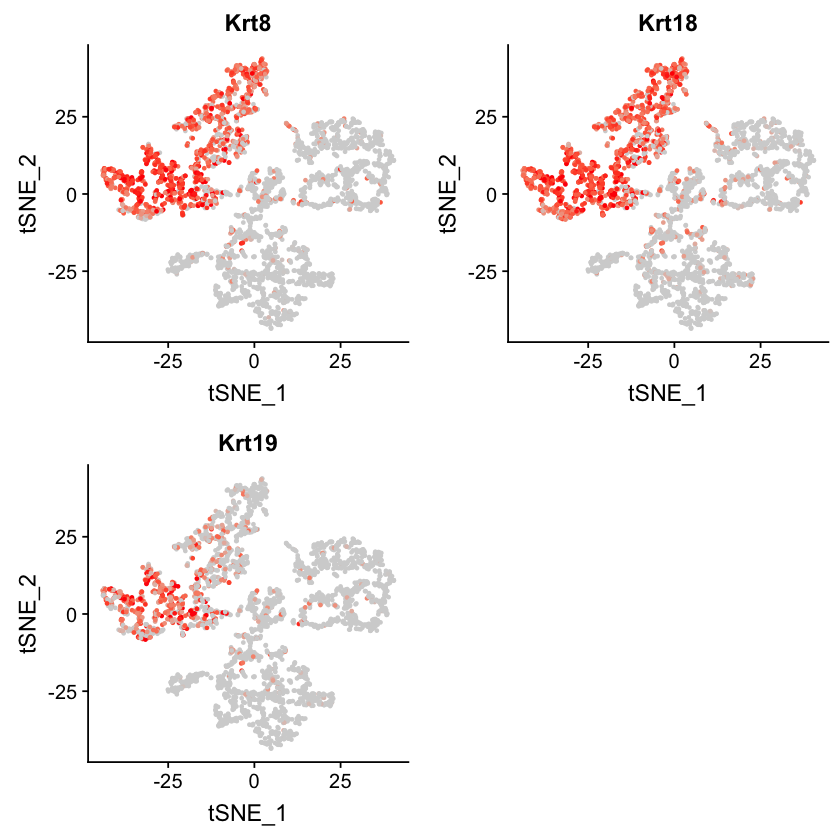

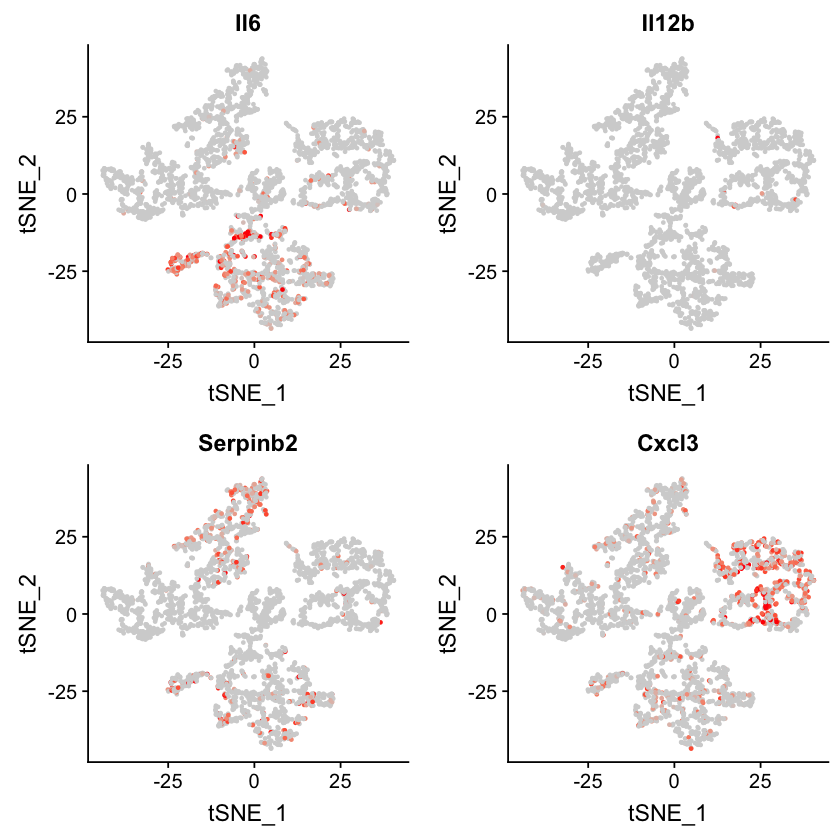

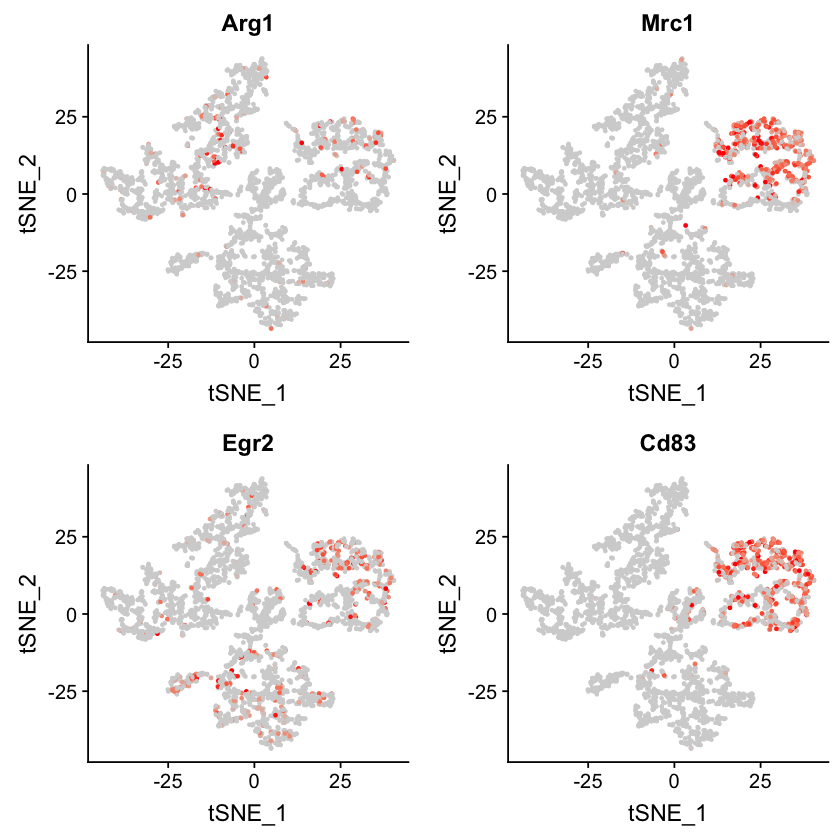

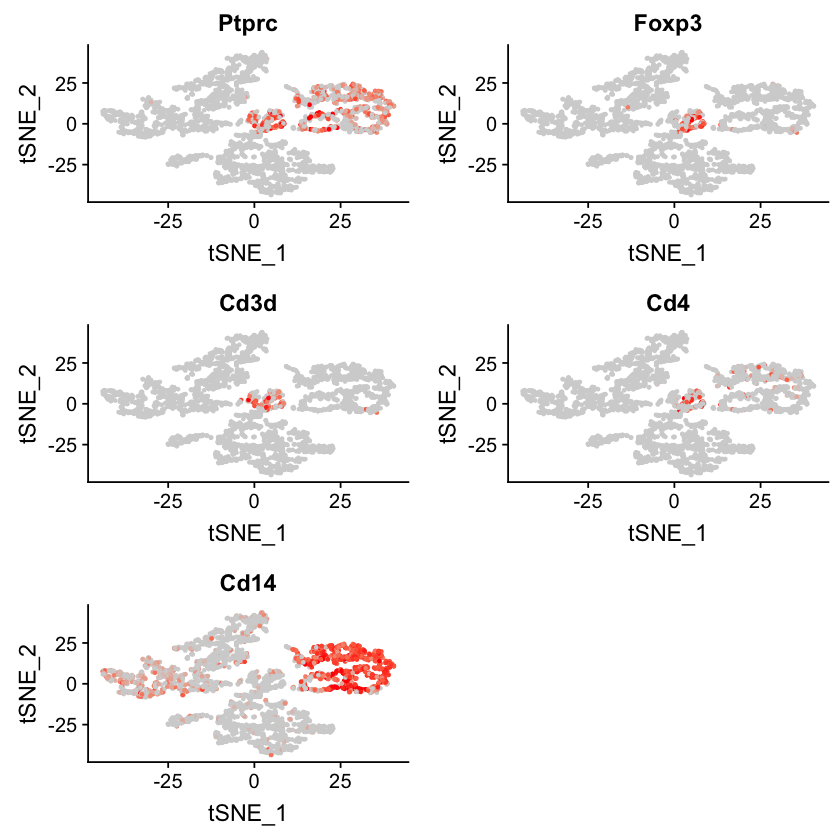

In [7]:
#######################################################################################
### Run multi-set Canonical Correlation Analysis (CCA) on the common genes across all the genesets
### Calculate the ratio of total variance explained by PPCA vs total variance explained by CCA,
###       and filter cells based on these values
### CCA Align the matrices and compute the alignment metric score
### Map a t-SNE plot and find clusters
#######################################################################################

cca_out = RunMultiCCA(seu_list,genes.use=genes_use,num.ccs = 20)
DimPlot(object = cca_out, reduction.use = "cca", group.by = "group", pt.size = 1, do.return = F)
VlnPlot(object = cca_out, features.plot = "CC1", group.by = "group", do.return = F)
MetageneBicorPlot(cca_out, grouping.var = "group", dims.eval = 1:20, display.progress = FALSE)
DimHeatmap(object = cca_out, reduction.type = "cca", cells.use = 500, dim.use = 1:9, do.balanced = TRUE)
cca_out = CalcVarExpRatio(cca_out,reduction.type = "pca", grouping.var = "group", dims.use = 1:20)
cca_out = SubsetData(cca_out, subset.name = "var.ratio.pca",accept.low = 0.40)
cca_out = AlignSubspace(cca_out, reduction.type = "cca", grouping.var = "group", dims.align = 1:10,num.genes=50)
metric = rep(0,10)
for(i in 1:10){
  metric[i]=CalcAlignmentMetric(cca_out,reduction.use = "cca.aligned",dims.use = 1:i, grouping.var =  "group")
  cat("Number of PCs: ",i," Alignment metric: ",metric[i],"\n")
}
dim_max = metric[3]
dim_max
cca_out = RunTSNE(cca_out, reduction.use = "cca.aligned", dims.use = 1:3, do.fast = T,check_duplicates=F)
TSNEPlot(object = cca_out, do.label = F,group.by="group")
TSNEPlot(object = cca_out, do.label = F,no.legend = FALSE,dark.theme = FALSE,label.size=5,group.by="Phase")
cca_out = FindClusters(cca_out, reduction.type = "cca.aligned", resolution = c(0.6), dims.use = 1:3,print.output = F)
TSNEPlot(object = cca_out, do.label =T,no.legend = FALSE,dark.theme = FALSE,label.size=5)
FeaturePlot(cca_out, features.plot = c("Krt5","Krt14","Krt6a"), reduction.use="tsne",nCol=2,min.cutoff = "q05", max.cutoff = "q95", cols.use = c("lightgrey", "red"), pt.size = 1)
FeaturePlot(cca_out, features.plot = c("Krt8","Krt18","Krt19"), reduction.use="tsne",nCol=2,min.cutoff = "q05", max.cutoff = "q95", cols.use = c("lightgrey", "red"), pt.size = 1)
FeaturePlot(cca_out, features.plot = c("Il6","Il12b","Serpinb2","Cxcl3"), reduction.use="tsne",nCol=2,min.cutoff = "q05", max.cutoff = "q95", cols.use = c("lightgrey", "red"), pt.size = 1)
FeaturePlot(cca_out, features.plot = c("Arg1","Mrc1","Egr2","Cd83"), reduction.use="tsne",nCol=2,min.cutoff = "q05", max.cutoff = "q95", cols.use = c("lightgrey", "red"), pt.size = 1)
FeaturePlot(cca_out, features.plot = c("Ptprc","Foxp3","Cd3d","Cd4","Cd14"), reduction.use="tsne",nCol=2,min.cutoff = "q05", max.cutoff = "q95", cols.use = c("lightgrey", "red"), pt.size = 1)


Characterize the clusters using known gene-sets and computed single sample gene-set enrichment scores.

In [8]:
ssgsea_out = gsva(as.matrix(cca_out@data),gset.idx.list=ach$genesets,method="ssgsea",kcdf="Gaussian",min.sz=1,max.sz=1000)

Estimating ssGSEA scores for 49 gene sets.
  |                                                                      |   0%Using parallel with 4 cores
  |======================================================================| 100%


Using Cluster, Group as id variables


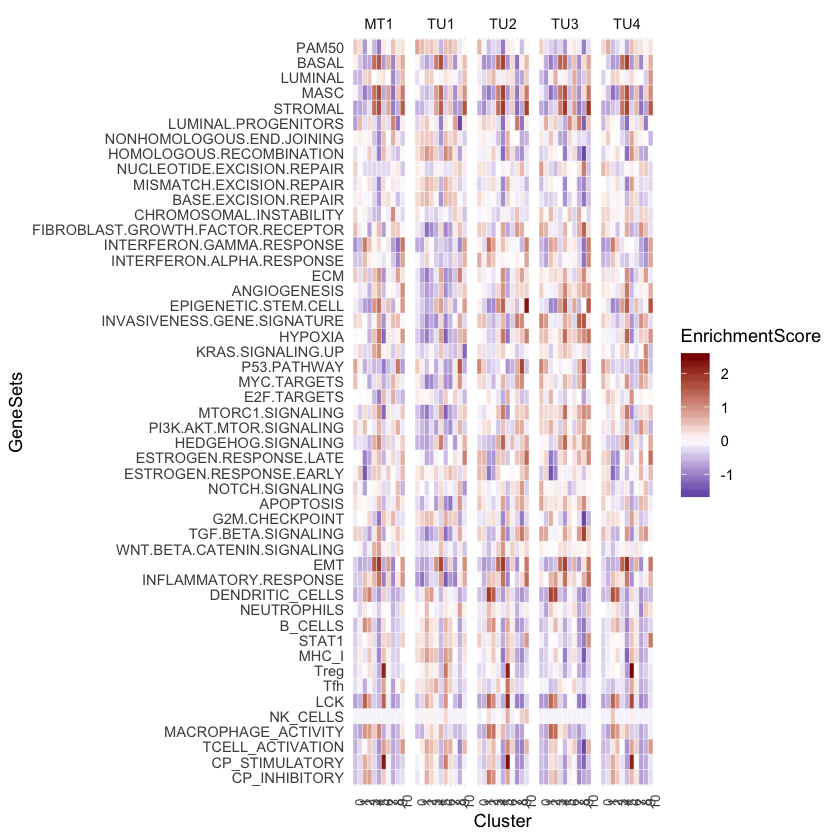

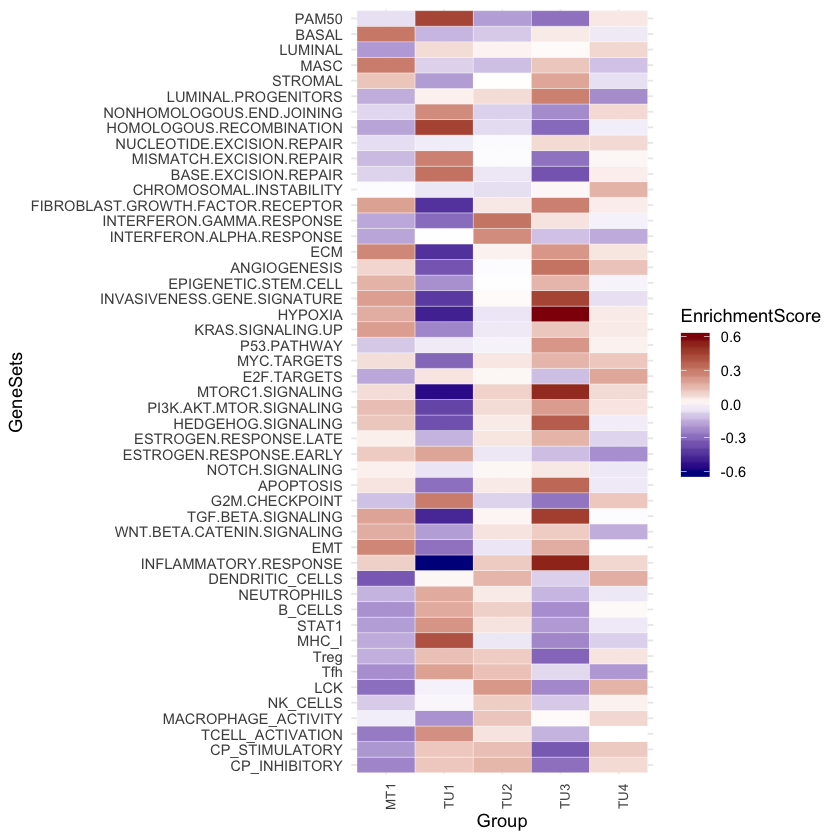

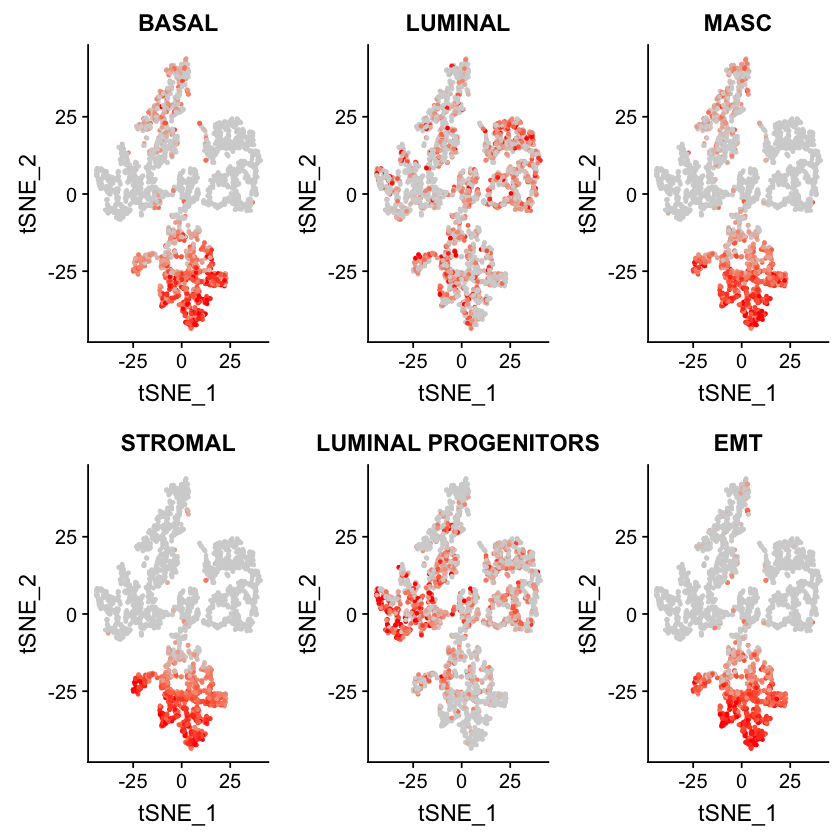

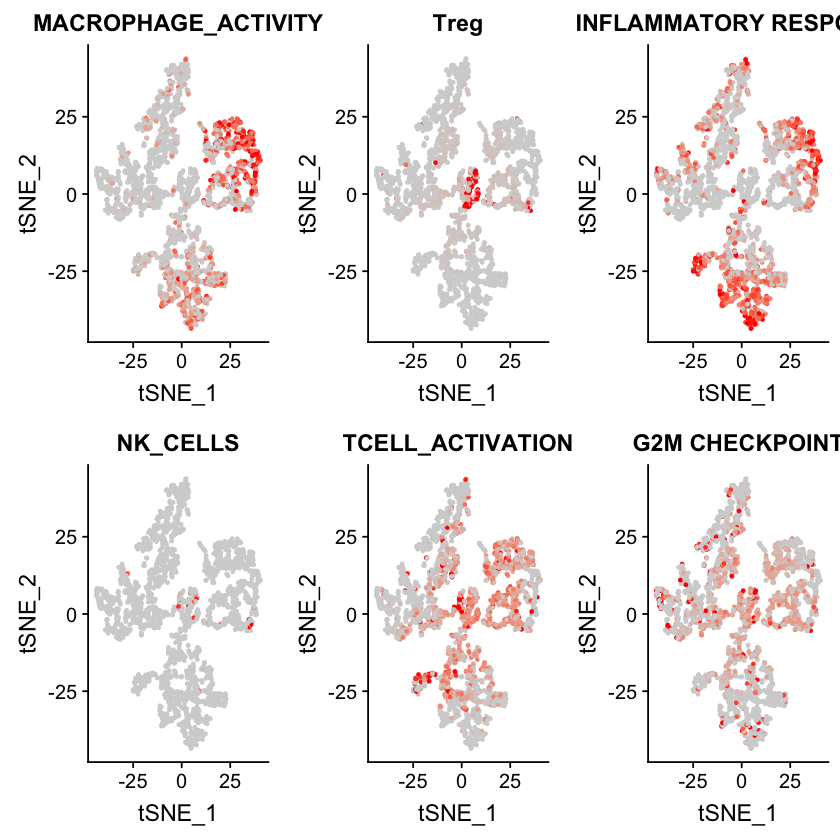

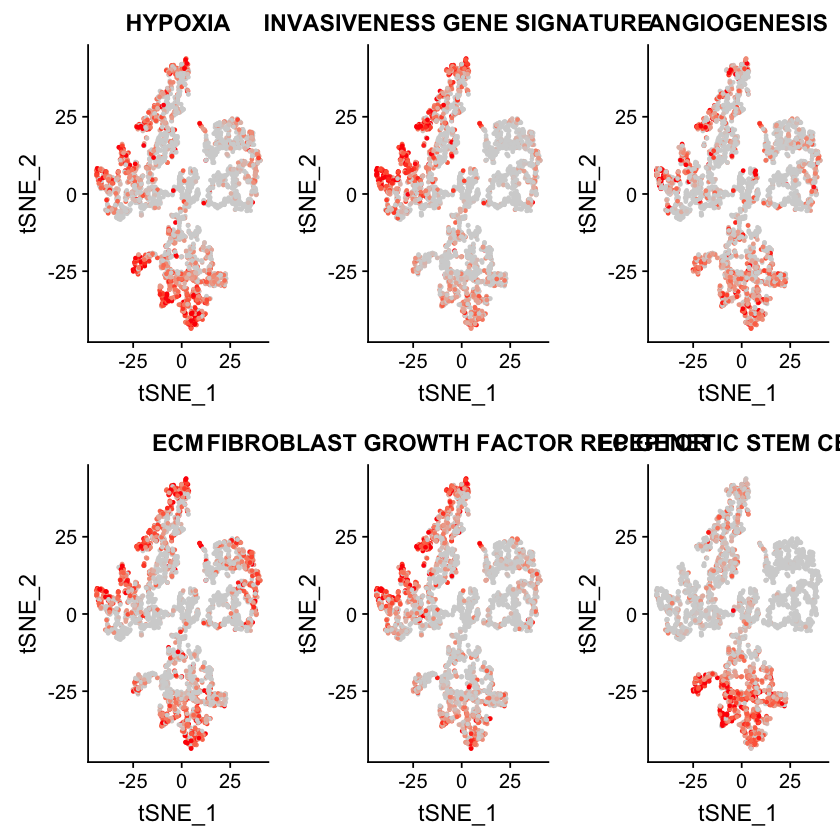

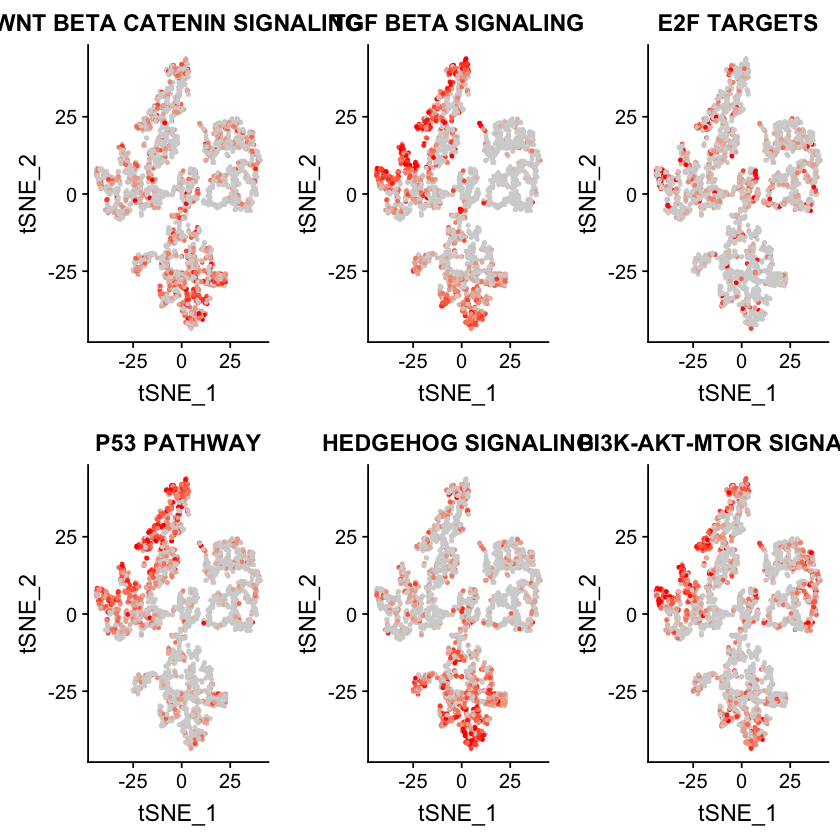

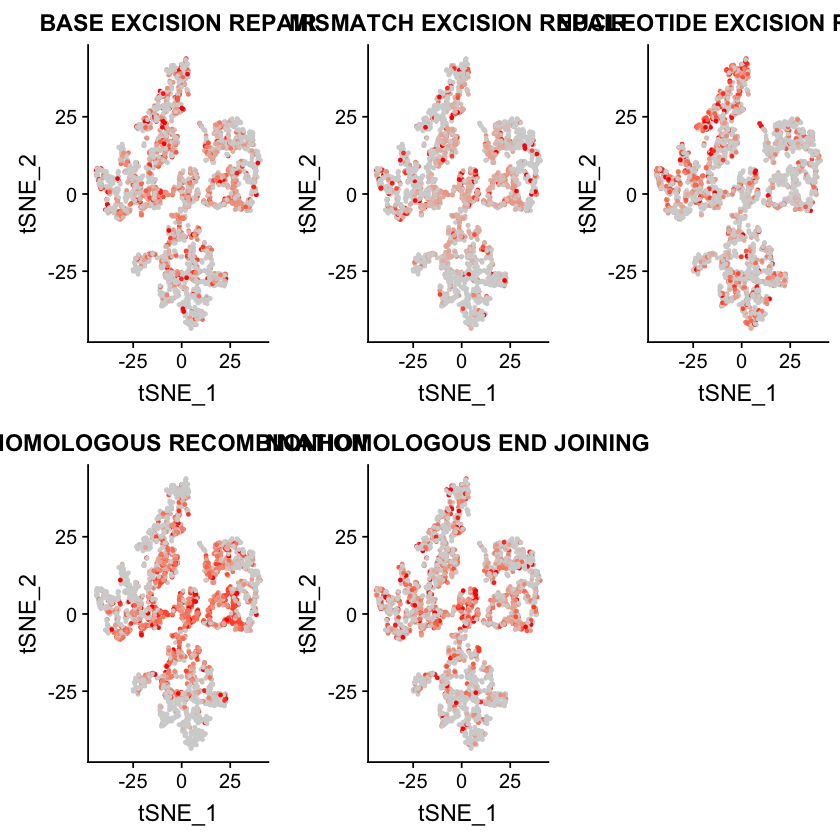

In [9]:
FM = ssgsea_out
FM = as.matrix(Matrix::t(scale(Matrix::t(FM))))
FM = melt(data.frame(t(FM),"Cluster"=cca_out@ident,"Group"=cca_out@meta.data$group))
colnames(FM)[3:4]=c("GeneSets","EnrichmentScore")
### Heatmap of cluster-wise gene-set enrichment scores for every gene-set
ES_mean = FM %>% dplyr::group_by(Cluster,GeneSets,Group) %>% summarize_all(list(mean))
ggplot(ES_mean, aes(Cluster, GeneSets)) + geom_tile(aes(fill = EnrichmentScore), colour = "white") + scale_fill_gradient2(low ="dark blue", high ="dark red", mid ="white",space = "Lab") +
      theme_minimal() + theme(axis.text.x=element_text(size=8,angle=90)) + facet_grid(~Group)
ES1_mean = FM[,-1] %>% dplyr::group_by(GeneSets,Group) %>% summarize_all(list(mean))
ggplot(ES1_mean, aes(Group, GeneSets)) + geom_tile(aes(fill = EnrichmentScore), colour = "white") + scale_fill_gradient2(low ="dark blue", high ="dark red", mid ="white",space = "Lab") +
      theme_minimal() + theme(axis.text.x=element_text(size=8,angle=90))
cca_out@meta.data = cbind(cca_out@meta.data,t(as.matrix(Matrix::t(scale(Matrix::t(ssgsea_out))))))
FeaturePlot(cca_out,features.plot=c("BASAL","LUMINAL","MASC","STROMAL","LUMINAL PROGENITORS","EMT"),reduction.use="tsne",nCol=3,min.cutoff = "q05", max.cutoff = "q95", cols.use = c("lightgrey", "red"), pt.size = 1)
FeaturePlot(cca_out,features.plot=c("MACROPHAGE_ACTIVITY","Treg","INFLAMMATORY RESPONSE","NK_CELLS","TCELL_ACTIVATION","G2M CHECKPOINT"),reduction.use="tsne",nCol=3,min.cutoff = "q05", max.cutoff = "q95", cols.use = c("lightgrey", "red"), pt.size = 1)
FeaturePlot(cca_out,features.plot=c("HYPOXIA","INVASIVENESS GENE SIGNATURE","ANGIOGENESIS","ECM","FIBROBLAST GROWTH FACTOR RECEPTOR","EPIGENETIC STEM CELL"),reduction.use="tsne",nCol=3,min.cutoff = "q05", max.cutoff = "q95", cols.use = c("lightgrey", "red"), pt.size = 1)
FeaturePlot(cca_out,features.plot=c("WNT BETA CATENIN SIGNALING","TGF BETA SIGNALING","E2F TARGETS","P53 PATHWAY","HEDGEHOG SIGNALING","PI3K-AKT-MTOR SIGNALING"),reduction.use="tsne",nCol=3,min.cutoff = "q05", max.cutoff = "q95", cols.use = c("lightgrey", "red"), pt.size = 1)
FeaturePlot(cca_out,features.plot=c("BASE EXCISION REPAIR","MISMATCH EXCISION REPAIR","NUCLEOTIDE EXCISION REPAIR","HOMOLOGOUS RECOMBINATION","NONHOMOLOGOUS END JOINING"),reduction.use="tsne",nCol=3,min.cutoff = "q05", max.cutoff = "q95", cols.use = c("lightgrey", "red"), pt.size = 1)


Also used custom gene-sets and computed single sample gene-set enrichment scores to characterize the clusters.

Estimating ssGSEA scores for 8 gene sets.
  |                                                                      |   0%Using parallel with 4 cores
  |======================================================================| 100%


Using Cluster, Group as id variables


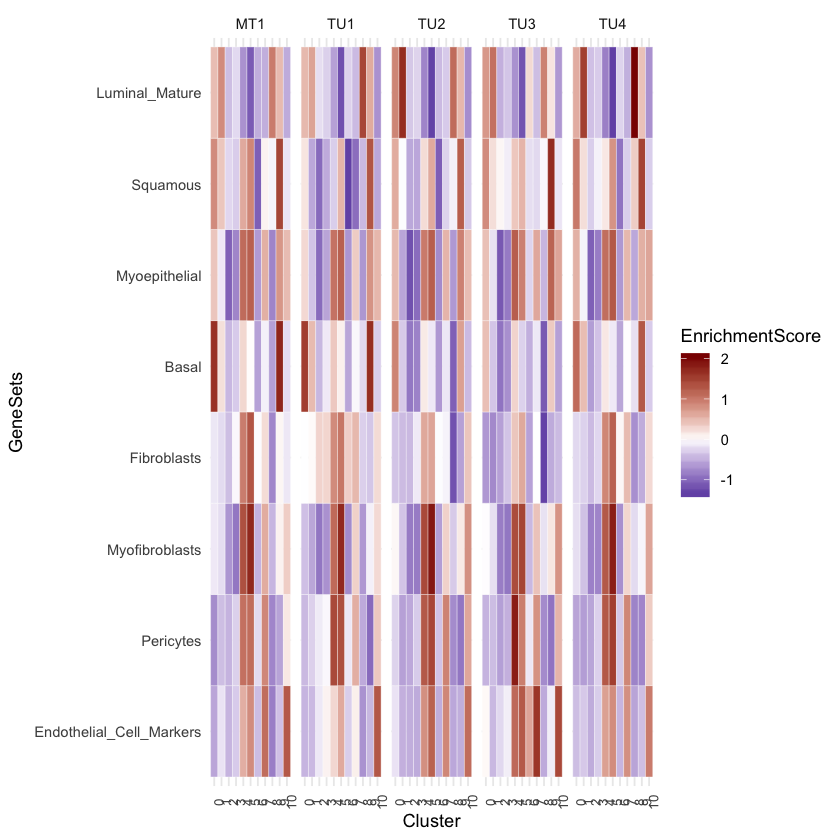

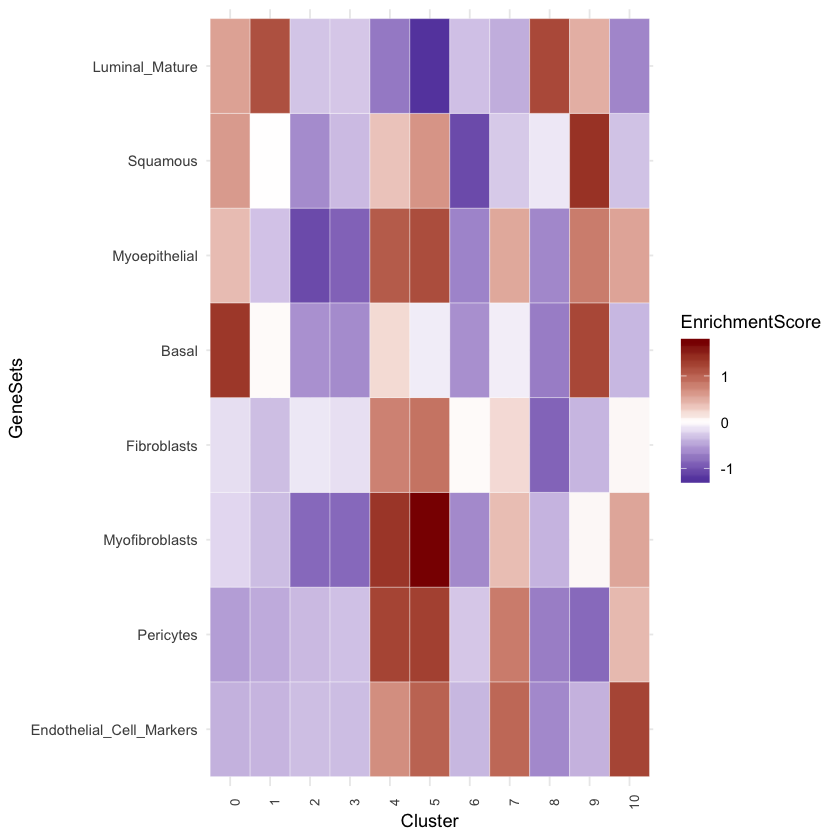

In [10]:
endothelial_cell_markers = c("Cdh5", "Epas1", "Kdr", "Pecam1", "Cd34", "Flt1", "Icam1", "Eng", "Mcam", "Sele", "Esm1", "Mmm2", "Emcn", "Cd248", "Ccl26", "Gbp2b", "Icam2", "Thbd" , "Lyve1", "Vegfa", "Robo4", "Adgra2", "Plxdc1", "Antxr1", "Vwf")
pericyte = c("Rgs5", "Angpt2", "Angpt1", "Pecam1", "Cspg4", "Pdgfrb", "Des", "Acta2", "Anpep", "Tek", "Tie1", "Mcam", "Cnn1", "Eng", "Ptgis", "Cd248", "Ng2")
myofibroblasts = c("Acta2", "Cdh11", "Des", "Tpm1", "Thy1", "Tgfb1", "Palld")
fibroblasts = c("Fsp1", "P4ha2")
basal = c("Cd44", "Cdh3", "S100a6", "Krt14", "Krt16", "Krt6a", "Krt5", "Krt17", "Col18a1", "Moxd", "Nrg1", "Snai2", "Trp63", "Tpm2", "Igfbp3")
myoepithelial = c("Sfn", "Acta2", "Cald1", "Cnn1", "Car3", "Mme", "Serpinb5", "Sparc", "Vim", "Thy1", "Myhs", "Ngfr", "Trp63", "Nrp1", "Nes", "Krt14", "Krt17", "Egfr")
squamous = c("Spp1", "Serpine1", "Akp3", "Cd44", "Krt14", "Krt17", "Eno2", "Slc2a1", "Mmp9", "Mmp8", "Hnrnpa2b1", "Ccnd1", "Cdkn1a", "L1cam")
luminal_mature = c("Krt19", "Krt18", "Krt8", "Foxa1", "Prlr", "Areg", "Cldn7", "Cldn4", "Tacstd2", "Cited1", "Gipc2", "Tmem56", "Lgals3", "Ly6d", "Stc2", "Mapk13", "Mlph", "Sytl2", "Tgm2", "Plekhg3")
new_gene_sets = list(endothelial_cell_markers,pericyte,myofibroblasts,fibroblasts,basal,myoepithelial,squamous,luminal_mature)
names(new_gene_sets)=c("Endothelial_Cell_Markers","Pericytes","Myofibroblasts","Fibroblasts","Basal","Myoepithelial","Squamous","Luminal_Mature")
ssgsea_out_new = gsva(as.matrix(cca_out@data),gset.idx.list=new_gene_sets,method="ssgsea",kcdf="Gaussian",min.sz=1,max.sz=1000)
FM1 = ssgsea_out_new
FM1 = as.matrix(Matrix::t(scale(Matrix::t(FM1))))
FM1 = melt(data.frame(t(FM1),"Cluster"=cca_out@ident,"Group"=cca_out@meta.data$group))
colnames(FM1)[3:4]=c("GeneSets","EnrichmentScore")
ES_mean = FM1 %>% dplyr::group_by(Cluster,GeneSets,Group) %>% summarize_all(list(mean))
ggplot(ES_mean, aes(Cluster, GeneSets)) + geom_tile(aes(fill = EnrichmentScore), colour = "white") + scale_fill_gradient2(low ="dark blue", high ="dark red", mid ="white",space = "Lab") +
      theme_minimal() + theme(axis.text.x=element_text(size=8,angle=90)) + facet_grid(~Group)
ES_mean = FM1[,-2] %>% dplyr::group_by(Cluster,GeneSets) %>% summarize_all(list(mean))
ggplot(ES_mean, aes(Cluster, GeneSets)) + geom_tile(aes(fill = EnrichmentScore), colour = "white") + scale_fill_gradient2(low ="dark blue", high ="dark red", mid ="white",space = "Lab") +
      theme_minimal() + theme(axis.text.x=element_text(size=8,angle=90))


We focus on clusters 0,2,8 and 9 for futher analyses. Given the expression of known cytokeratins, we identified basal-like (clusters 0 & 9) and luminal-like (clusters 1 & 8) and further explored them using trajectory maps.

In [11]:
library(monocle);

Loading required package: Biobase
Loading required package: BiocGenerics
Loading required package: parallel

Attaching package: ‘BiocGenerics’

The following object is masked _by_ ‘.GlobalEnv’:

    normalize

The following objects are masked from ‘package:parallel’:

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB

The following objects are masked from ‘package:dplyr’:

    combine, intersect, setdiff, union

The following object is masked from ‘package:Matrix’:

    which

The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs

The following objects are masked from ‘package:base’:

    anyDuplicated, append, as.data.frame, basename, cbind, colnames,
    dirname, do.call, duplicated, eval, evalq, Filter, Find, get, grep,
    grepl, intersect, is.unsorted, lapply, Map, mapply, match, mget,
    order, paste, pmax, pmax.int, pmin, pm

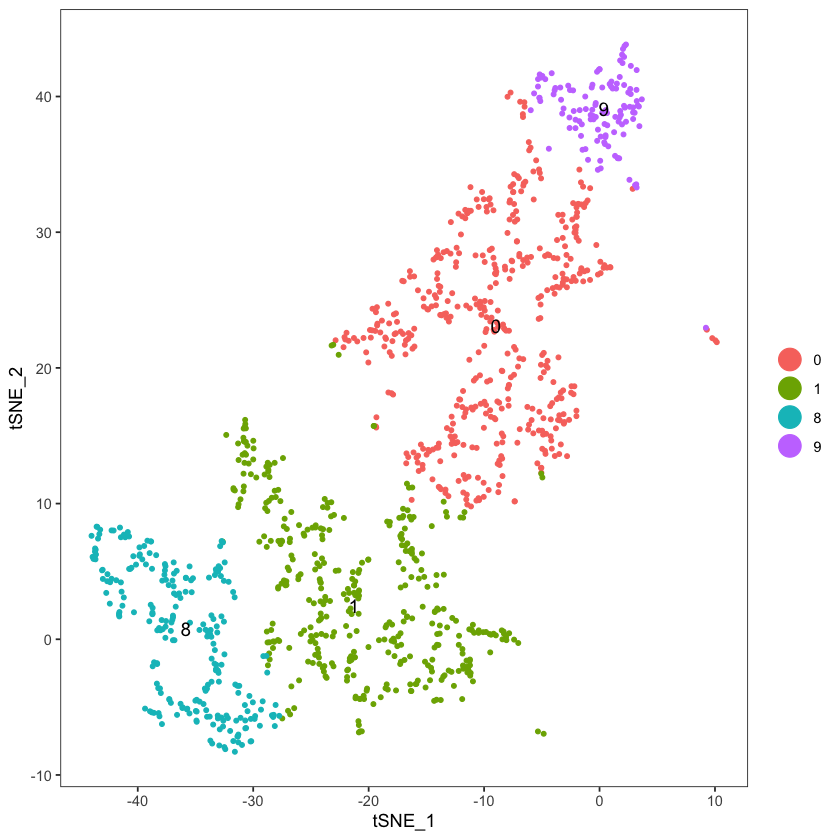

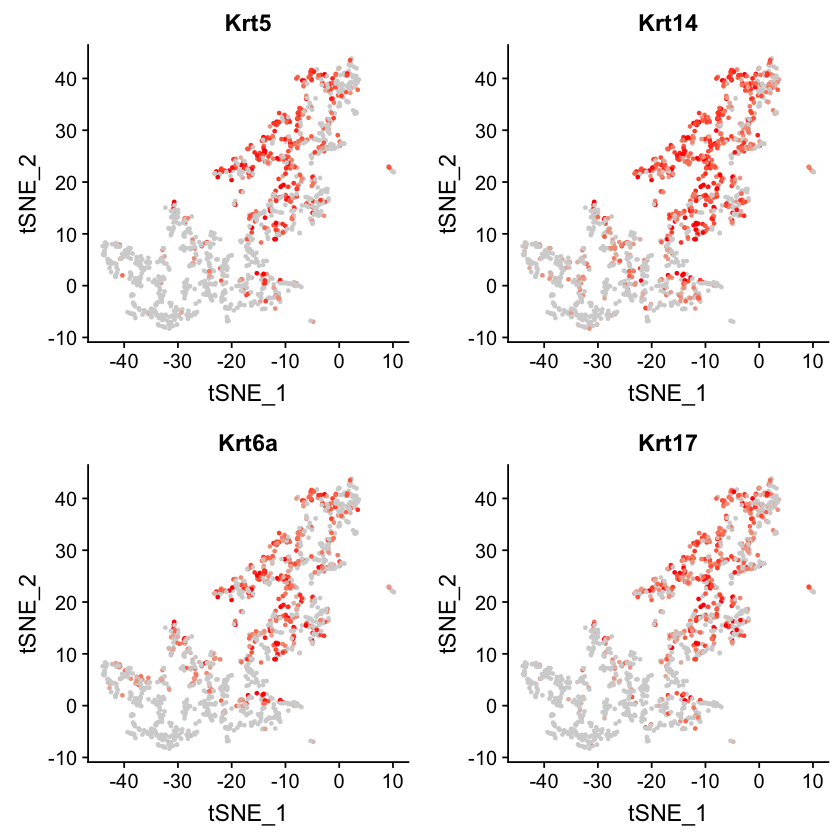

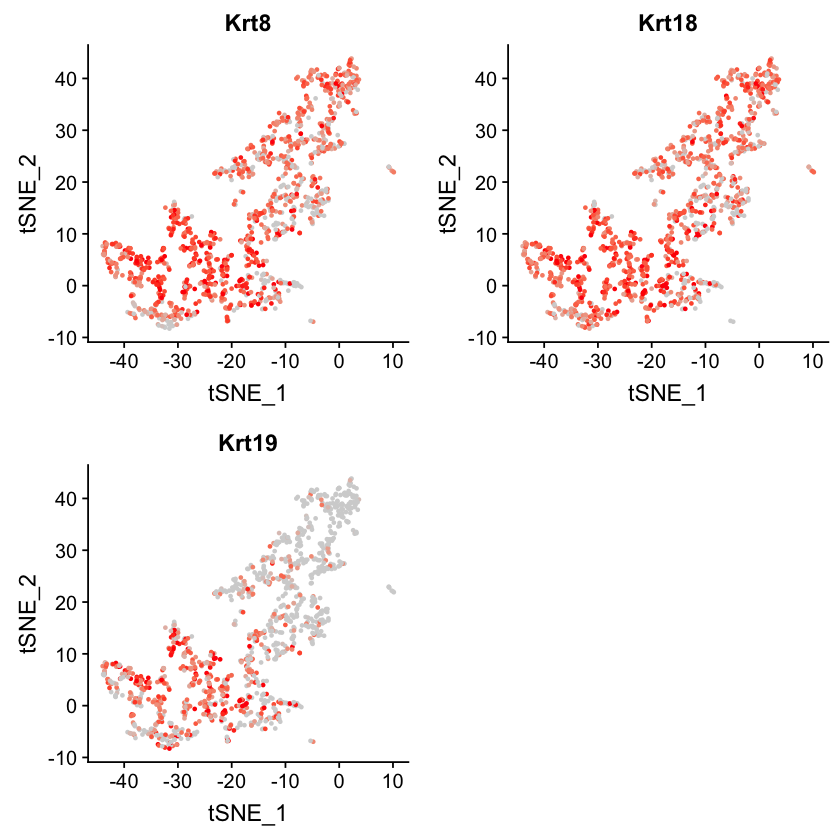

In [12]:
group2 = c(1,8);
group1 = c(0,9);

cca_new = SubsetData(cca_out,ident.use=c(group1,group2))
TSNEPlot(object = cca_new, do.label = T)
FeaturePlot(cca_new, features.plot = c("Krt5","Krt14","Krt6a","Krt17"), reduction.use="tsne",nCol=2,min.cutoff = "q05", max.cutoff = "q95", cols.use = c("lightgrey", "red"), pt.size = 1)
FeaturePlot(cca_new, features.plot = c("Krt8","Krt18","Krt19"), reduction.use="tsne",nCol=2,min.cutoff = "q05", max.cutoff = "q95", cols.use = c("lightgrey", "red"), pt.size = 1)


We identify top differentially expressed genes using samples from these 4 clusters.

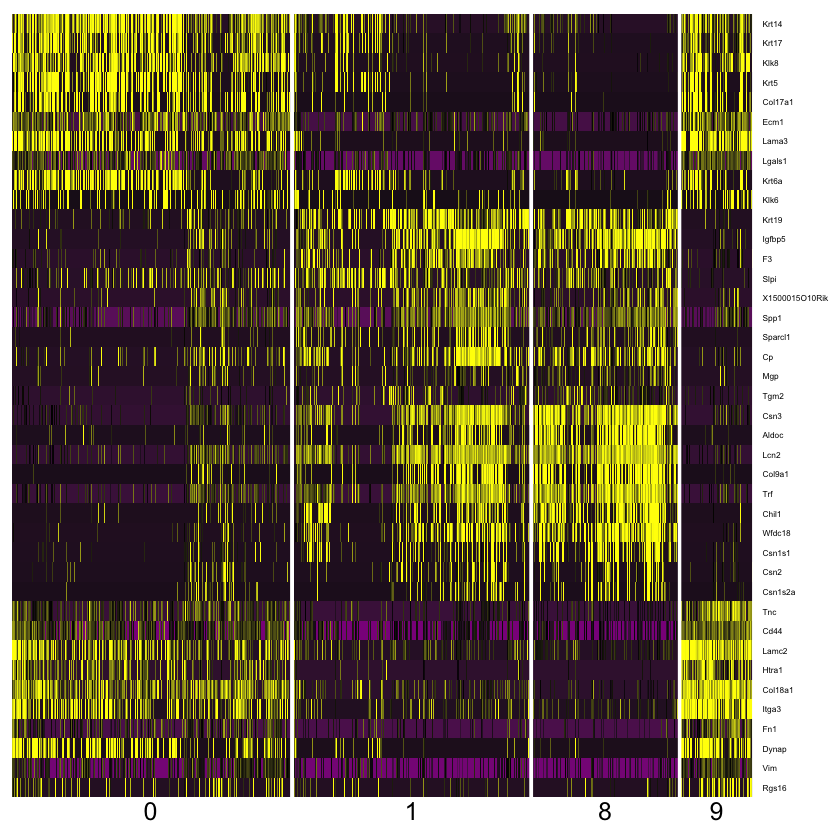

In [13]:
markers <- FindAllMarkers(object = cca_new,only.pos = FALSE, min.pct = 0.25, thresh.use = 0.25)
top10 = markers %>% group_by(cluster) %>% top_n(10, avg_logFC)
DoHeatmap(object = cca_new, genes.use = top10$gene, slim.col.label = TRUE, remove.key = TRUE,cex.row = 5)

Trajectory mapping of cells in clusters 0, 1, 8 and 9 using Monocle (DDRTree approach). First, convert Seurat object to Monocle object. 

In [14]:
cds = importCDS(cca_new,import_all=T)
dim(cds)
cds = estimateSizeFactors(cds)
cds = estimateDispersions(cds)
cds = detectGenes(cds, min_expr = 0.1)
expressed_genes = row.names(subset(fData(cds),num_cells_expressed >= 10))
mycds = cds[expressed_genes,]

Features  Samples 
   13411     1226

Removing 246 outliers


Since trajectory mapping using DDRTree method is a machine learning problem, we start with feature selection (dpFeature) by selecting genes that define cell's progress.

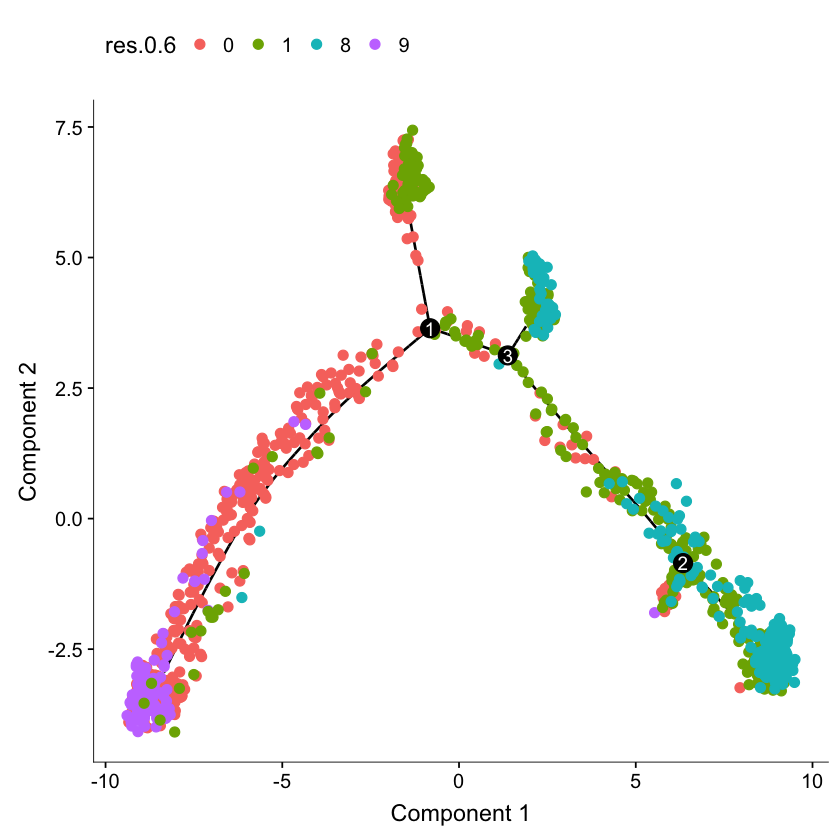

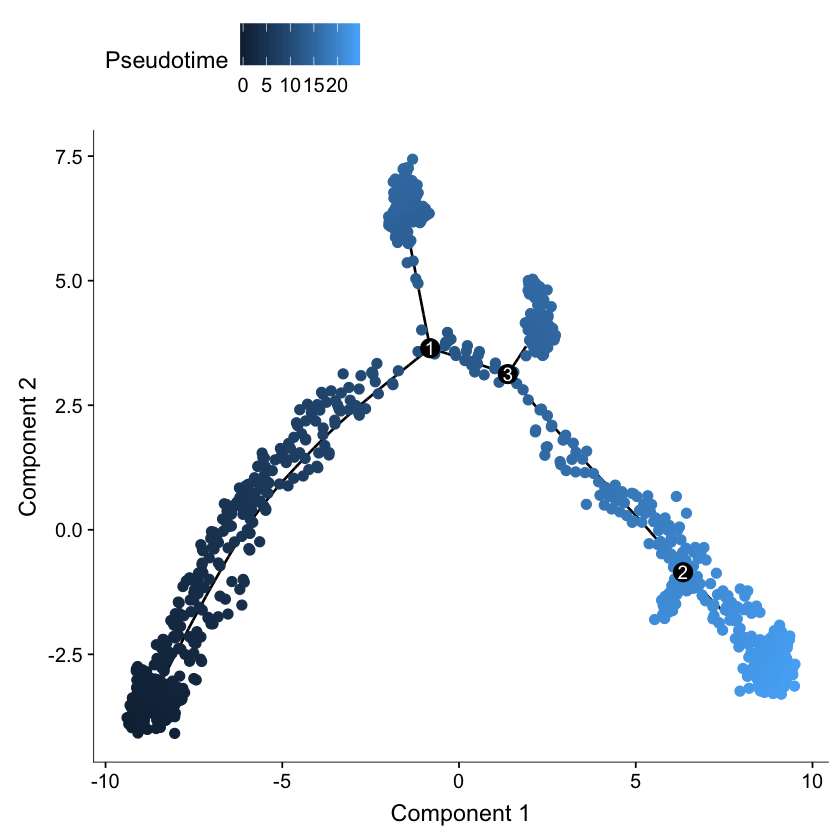

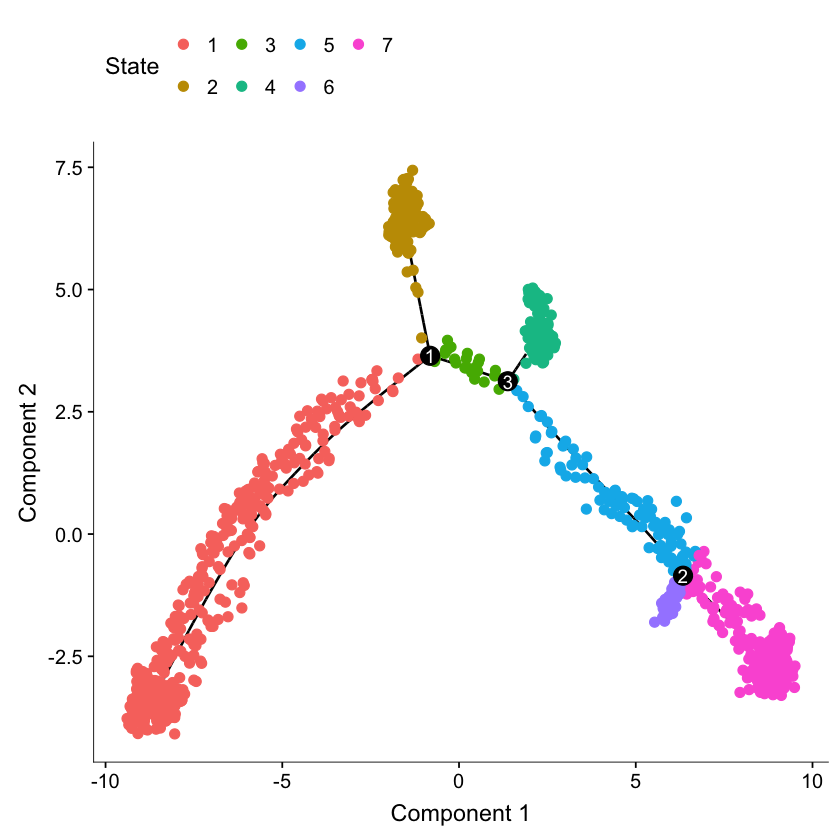

In [15]:
diff_test_res = differentialGeneTest(mycds,fullModelFormulaStr = "~res.0.6")
diff_test_res = diff_test_res[order(diff_test_res$pval),]
diff_test_sig = subset(diff_test_res,diff_test_res$qval<=0.01)
ordering_genes = row.names(diff_test_sig)
mycds = setOrderingFilter(mycds, ordering_genes)
mycds = reduceDimension(mycds, max_components = 2,method = 'DDRTree')
mycds = orderCells(mycds)
plot_cell_trajectory(mycds, color_by = "res.0.6",cell_size = 2.5)
plot_cell_trajectory(mycds, color_by = "Pseudotime",cell_size = 2.5)
plot_cell_trajectory(mycds, color_by = "State",cell_size = 2.5)

Compute the percentage contribution of the tumor types in each cluster (not just clusters 0, 1, 8 and 9). There are three different tumor types in p95, WT/p95 and delta16 (D16). 

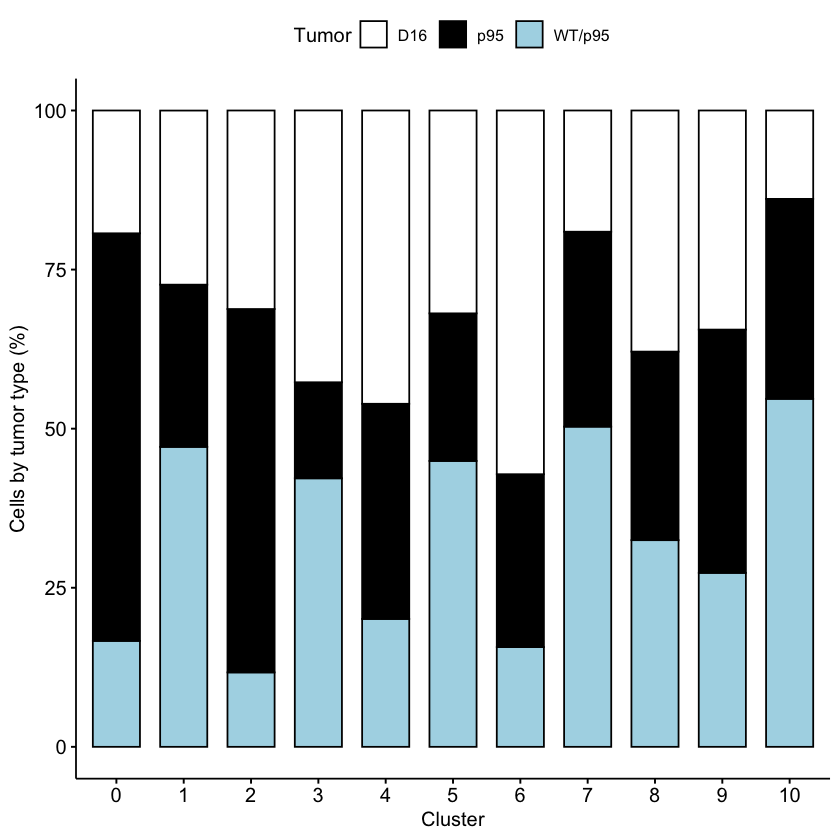

In [16]:
cca_out@meta.data$data = ifelse(cca_out@meta.data$group %in% c("MT1","TU1","TU4"),"p95",ifelse(cca_out@meta.data$group=="TU2","D16","WT/p95"))
temp = melt(prop.table(prop.table(table(cca_out@meta.data$res.0.6,cca_out@meta.data$data),2)*100,1)*100)
colnames(temp)[1:3] = c("Cluster","Tumor","Number")
temp$Cluster = factor(temp$Cluster,levels=c(0:10))
temp$Tumor = as.factor(temp$Tumor)
temp$Number = round(temp$Number,2)
ggbarplot(temp,x="Cluster",y="Number",fill="Tumor",ylab="Cells by tumor type (%)",palette=c("white","black","light blue"),label=F)

We define the "basal-ness" and "luminal-ness" in each clusters based on averaged gene expression of cytokeratins.

In [17]:
genes = c("Krt5","Krt6a", "Krt14", "Krt17","Krt8","Krt18","Krt19")
cca_sub = data.frame(apply(as.matrix(cca_out@data[rownames(cca_out@data) %in% genes,]),1,scale))
cca_sub$group = cca_out@meta.data$group
cca_sub$cluster = cca_out@meta.data$res.0.6
cca_sub = melt(cca_sub)
cca_sub$tumor_type = ifelse(cca_sub$variable %in% c("Krt8","Krt18","Krt19"),"Luminal","Basal")
cca_sub$tumor_type = as.factor(cca_sub$tumor_type)
cca_sub$group = as.factor(cca_sub$group)
cca_sub$cluster = factor(cca_sub$cluster,levels=c(0:10))
cca_sub$variable = factor(cca_sub$variable,levels=c("Krt8", "Krt18", "Krt19","Krt5","Krt6a","Krt14","Krt17"))


Using group, cluster as id variables


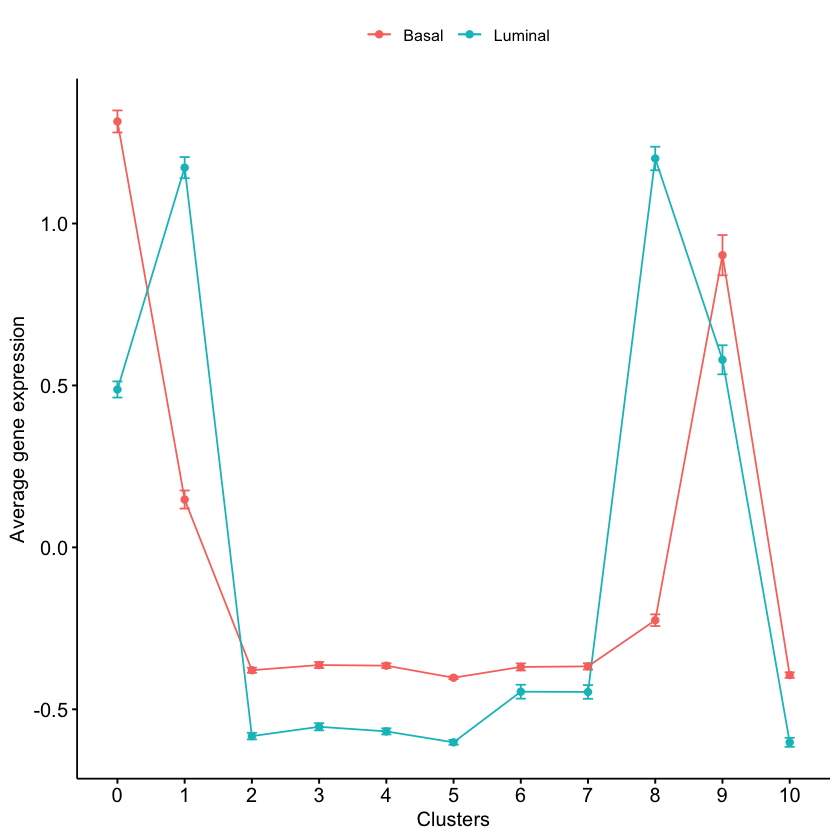

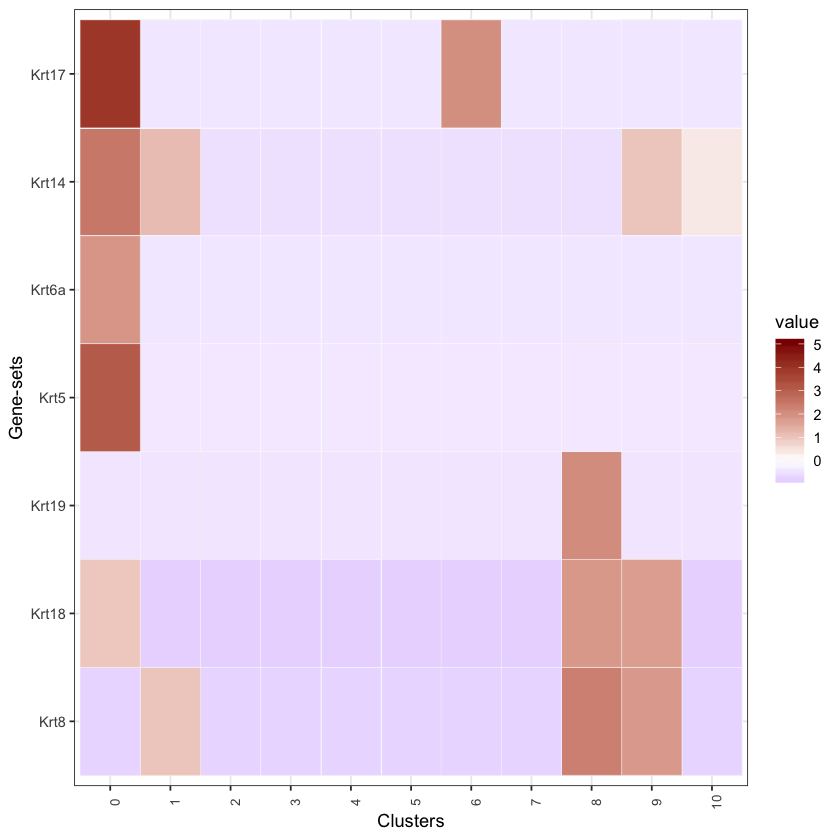

In [18]:
ggline(cca_sub,x="cluster",y="value",add = "mean_se",group="tumor_type",color="tumor_type",ylab="Average gene expression",xlab="Clusters") + theme(legend.title = element_blank())
ggplot(cca_sub, aes(cluster, variable)) + geom_tile(aes(fill = value), colour = "white") + scale_fill_gradient2(low ="blue", high ="dark red", mid ="white",space = "Lab") +
      theme_bw() + theme(axis.text.x=element_text(size=8,angle=90)) + xlab("Clusters") + ylab("Gene-sets")

Using a correlation density plot, we can correlate basal vs luminal markers such as cytokeratins. 


Attaching package: ‘gtools’

The following object is masked from ‘package:VGAM’:

    logit



[1] 1


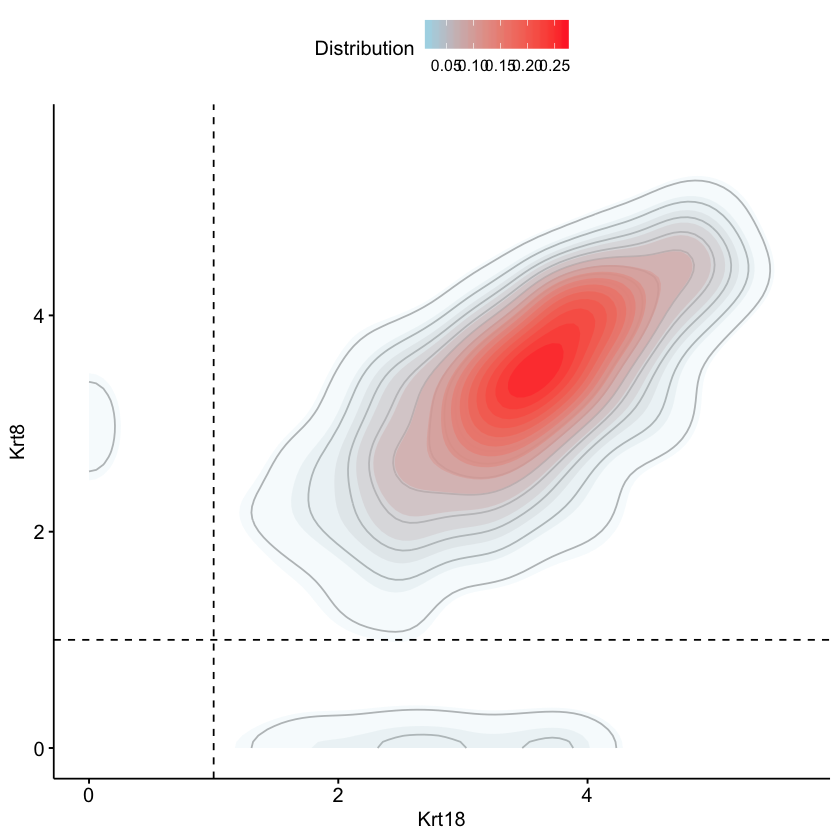

[1] 2


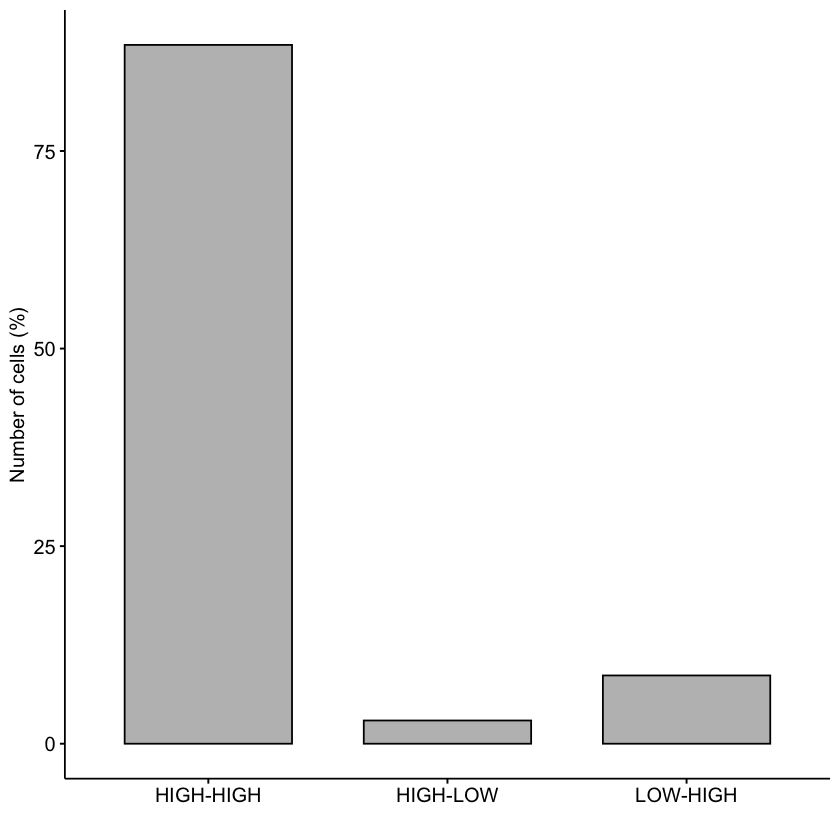

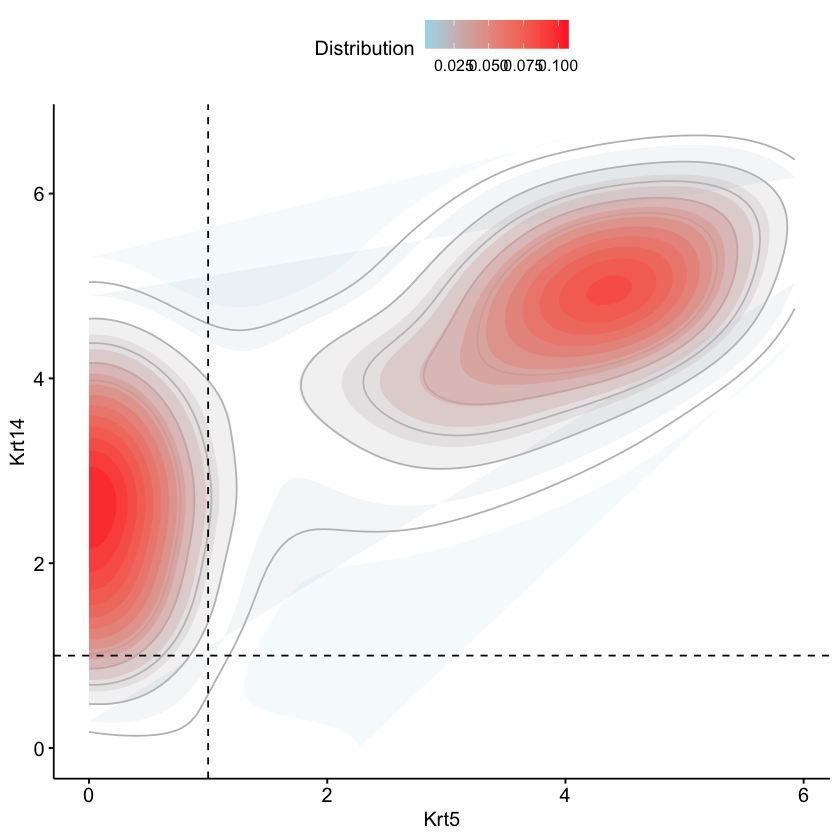

[1] 3


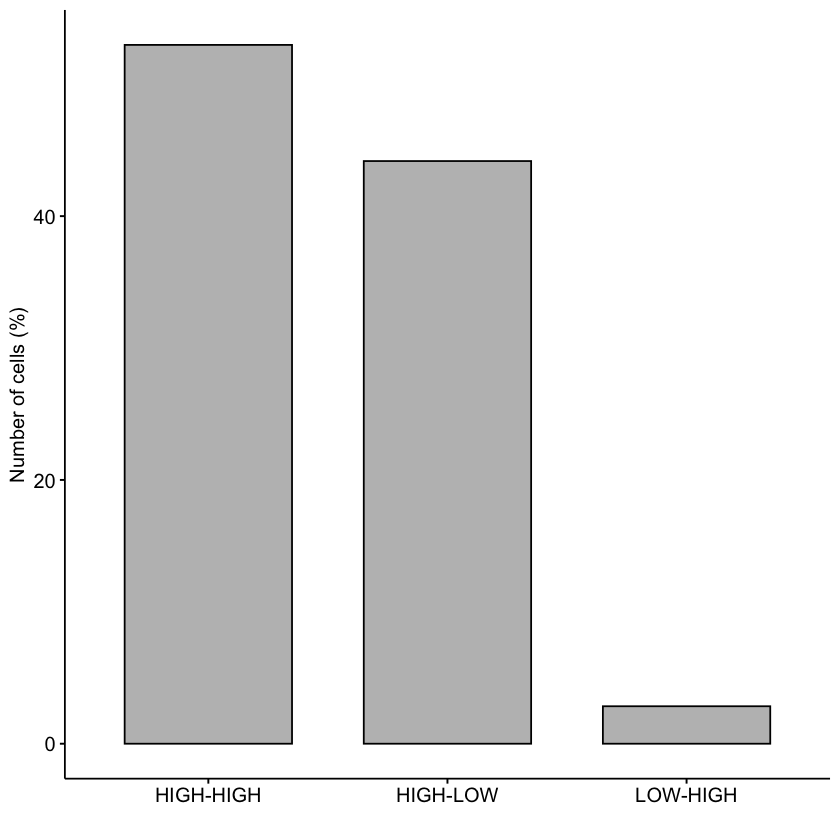

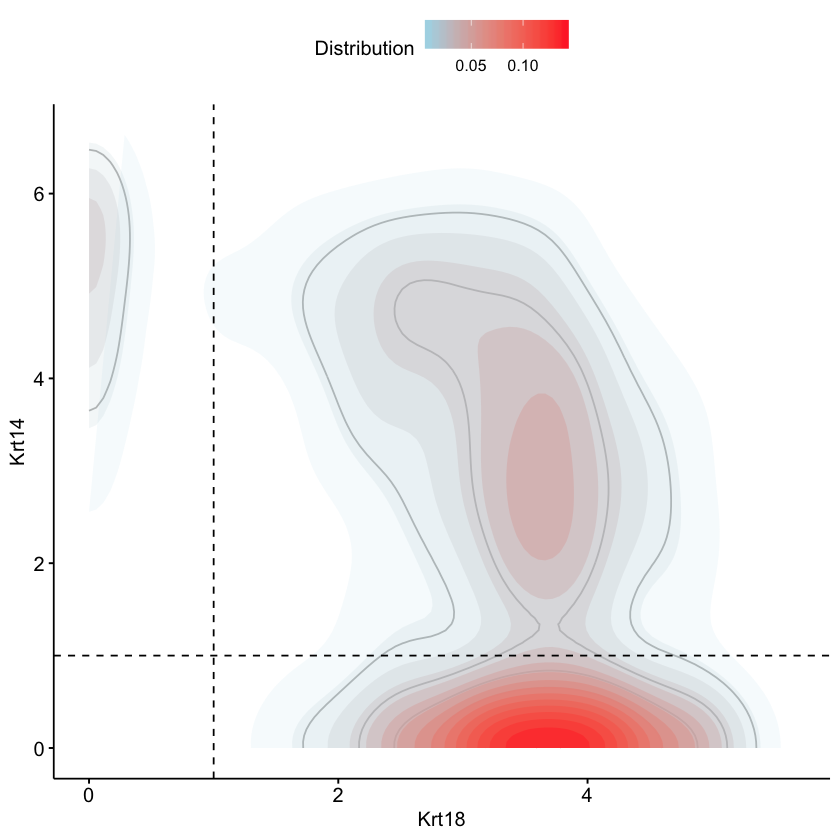

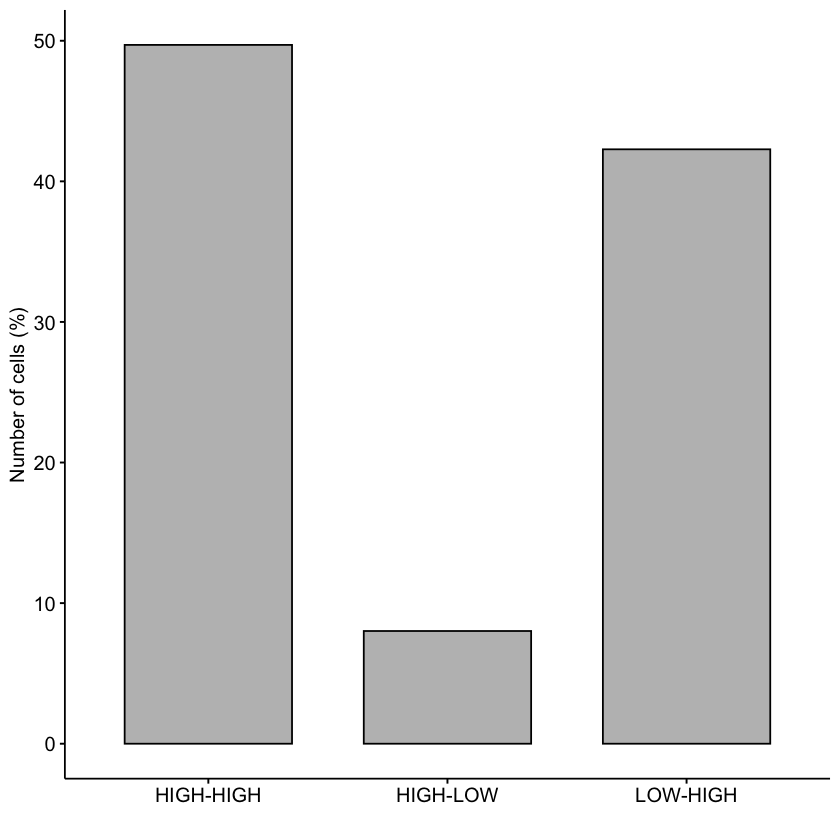

In [20]:
library(gtools)
cca_sub1 = data.frame(t(as.matrix(cca_out@data[rownames(cca_out@data) %in% genes,])))
cca_sub1$group = cca_out@meta.data$group
cca_sub1$cluster = cca_out@meta.data$res.0.6
cca_sub1 = subset(cca_sub1,cluster%in%c(0,1,8,9))
cca_sub1$cluster = factor(cca_sub1$cluster,levels=c(0,1,8,9))
perm = permutations(7,2,colnames(cca_sub1)[1:7])
perm1 = matrix(c("Krt18","Krt8","Krt5","Krt14","Krt18","Krt14"),3,2,byrow=T)
for(i in 1:nrow(perm1)){
	print(i)
	cca_sub2 = cbind(cca_sub1[,colnames(cca_sub1)%in%c(perm1[i,1],perm1[i,2])],cluster=cca_sub1$cluster)
	cca_sub2 = cca_sub2[which(rowSums(cca_sub2[,-3])!=0),]
	print(ggscatter(cca_sub2,x=perm1[i,1],y=perm1[i,2],color="white",fill="white")+geom_density2d(colour="grey")+
				stat_density2d(aes(fill=..level..,alpha = ..level..), size = 0.01, bins = 16,geom="polygon")+scale_fill_gradient(low="lightblue", high="firebrick1", name="Distribution")+guides(alpha="none")+
				geom_vline(xintercept=1, linetype="dashed")+geom_hline(yintercept=1, linetype="dashed"))
	cca_sub3 = cca_sub2
	cca_sub3 = data.frame(cbind(ifelse(cca_sub3[,-3]<0.1,"LOW","HIGH"),"cluster"=cca_sub3[,3]))
	cca_sub3$group = paste(cca_sub3[,1],cca_sub3[,2],sep="-")
	print(ggbarplot(melt(prop.table(table(cca_sub3$group))*100),x="Var1",y="value",fill="grey",xlab="",ylab="Number of cells (%)"))
}

Visualize gene expression of a selective few genes (that were also differentially expressed in state-specific analysis) as a heatmap.

Estimating ssGSEA scores for 2 gene sets.
  |                                                                      |   0%Using parallel with 4 cores
  |======================================================================| 100%


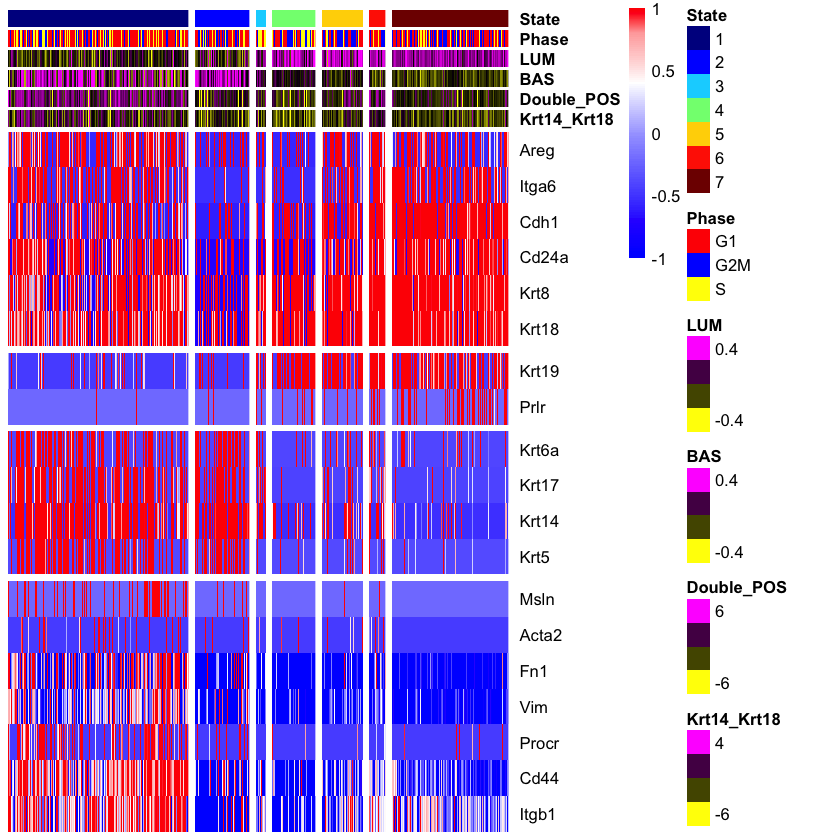

In [24]:
library(psych); library(RColorBrewer);library(pheatmap);
new_data = SubsetData(cca_out,cells.use=colnames(mycds),subset.raw=T)
mycds = mycds[,match(colnames(new_data@data),colnames(mycds))]
new_data@meta.data$State = pData(mycds)$State
new_data@meta.data$Pseudotime = pData(mycds)$Pseudotime
genes_to_plot = c("Krt14","Acta2","Cdh1","Fn1","Vim","Krt18","Cd44","Cd24a","mKO","EYFP","mTFP1","Itga6","Itgb1")
genes_to_plot1 = c("Krt5","Krt6a","Krt14","Krt17","Krt8","Krt18","Krt19","Areg","Prlr","Procr","Msln")
genes_to_plot2 = unique(c(genes_to_plot,genes_to_plot1))
genes_bas = c("Krt5" , "Krt6a" ,"Krt14", "Krt17"); genes_lum = c("Krt18", "Krt19", "Krt8")
new_data2 = data.frame(new_data@scale.data)
meta_data2 = new_data@meta.data
meta_data2 = meta_data2[order(meta_data2$State),]
new_data2 = new_data2[,match(rownames(meta_data2),colnames(new_data2))]
new_data2 = new_data2[rownames(new_data2) %in% genes_to_plot2,]
new_data3 = as.matrix(new_data@raw.data[match(c(genes_bas,genes_lum),rownames(new_data@raw.data)),])
new_data3 = new_data3[,match(rownames(meta_data2),colnames(new_data3))]
new_data4 = new_data3[rownames(new_data3) %in% c("Krt18","Krt14"),]
double_pos1 = geometric.mean(new_data3+0.01)
double_pos2 = geometric.mean(new_data4+0.01)
new_data2_gsva = gsva(as.matrix(new_data2),list(genes_bas,genes_lum),method="ssgsea")
rownames(new_data2_gsva)=c("BAS","LUM")
meta_data2 = cbind(meta_data2,t(new_data2_gsva),log2(double_pos1),log2(double_pos2))
colnames(meta_data2)[65:66]=c("Krt14_Krt18","Double_POS")
mat = meta_data2[,c("Krt14_Krt18","Double_POS","BAS","LUM","Phase","State")]
col_breaks = c( seq(-1,0,length=50),               # for red
                seq(0.01,0.8,length=50),           # for yellow
                seq(0.81,1,length=50))             # for green
my_palette = rev(colorRampPalette(c("red", "white", "blue"))(n = 149))
my_palette2 = rev(colorRampPalette(c("magenta", "black", "yellow"))(n = 149))
my_palette3 = colorRampPalette(rev(brewer.pal(n = 7,name = "RdYlBu")))(149)
my_palette4 = rev(colorRampPalette(rev(brewer.pal(n = 9,name = "YlOrRd")))(149))
mat_col = list( Krt14_Krt18 = my_palette2,Double_POS = my_palette2,BAS=my_palette2,LUM=my_palette2,Phase=c("red","blue","yellow"),State=matlab.colors(7))
names(mat_col[[5]])=levels(mat$Phase)
names(mat_col[[6]])=levels(mat$State)
pheatmap(as.matrix(new_data2),color=my_palette,breaks=col_breaks,cluster_row=T,cluster_col=F,annotation_col=mat,annotation_colors =mat_col,show_colnames = F,cutree_rows=4,treeheight_row = 0,gaps_col=cumsum(table(meta_data2$State)))
